In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, auc
from sklearn.model_selection import KFold
torch.manual_seed(1)    # reproducible torch:2 np:3
np.random.seed(1)

from config import BIN_config_DBPE
from models import BIN_Interaction_Flat
from stream import BIN_Data_Encoder

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
def test(data_generator, model):
    y_pred = []
    y_label = []
    model.eval()
    loss_accumulate = 0.0
    count = 0.0
    for i, (d, p, d_mask, p_mask, label) in enumerate(data_generator):
        score = model(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())
        
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score))
        loss_fct = torch.nn.BCELoss()            
        
        label = Variable(torch.from_numpy(np.array(label)).float()).cuda()

        loss = loss_fct(logits, label)
        
        loss_accumulate += loss
        count += 1
        
        logits = logits.detach().cpu().numpy()
        
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()
        
    loss = loss_accumulate/count
    
    fpr, tpr, thresholds = roc_curve(y_label, y_pred)

    precision = tpr / (tpr + fpr)

    f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

    thred_optim = thresholds[5:][np.argmax(f1[5:])]

    print("optimal threshold: " + str(thred_optim))

    y_pred_s = [1 if i else 0 for i in (y_pred >= thred_optim)]

    auc_k = auc(fpr, tpr)
    print("AUROC:" + str(auc_k))
    print("AUPRC: "+ str(average_precision_score(y_label, y_pred)))

    cm1 = confusion_matrix(y_label, y_pred_s)
    print('Confusion Matrix : \n', cm1)
    print('Recall : ', recall_score(y_label, y_pred_s))
    print('Precision : ', precision_score(y_label, y_pred_s))

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])
    return roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), y_pred, loss.item()


def main(fold_n, lr):
    config = BIN_config_DBPE()
    
    lr = lr
    BATCH_SIZE = config['batch_size']
    train_epoch = 100
    
    loss_history = []
    
    model = BIN_Interaction_Flat(**config)
    
    model = model.cuda()

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model, dim = 0)
            
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    #opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6, 
              'drop_last': True}

    dataFolder = './dataset/BindingDB'
    df_train = pd.read_csv(dataFolder + '/train.csv')
    df_val = pd.read_csv(dataFolder + '/val.csv')
    df_test = pd.read_csv(dataFolder + '/test.csv')
    
    training_set = BIN_Data_Encoder(df_train.index.values, df_train.Label.values, df_train)
    training_generator = data.DataLoader(training_set, **params)

    validation_set = BIN_Data_Encoder(df_val.index.values, df_val.Label.values, df_val)
    validation_generator = data.DataLoader(validation_set, **params)
    
    testing_set = BIN_Data_Encoder(df_test.index.values, df_test.Label.values, df_test)
    testing_generator = data.DataLoader(testing_set, **params)
    
    # early stopping
    max_auc = 0
    model_max = copy.deepcopy(model)
    
    print('--- Go for Training ---')
    torch.backends.cudnn.benchmark = True
    for epo in range(train_epoch):
        model.train()
        for i, (d, p, d_mask, p_mask, label) in enumerate(training_generator):
            score = model(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())

            label = Variable(torch.from_numpy(np.array(label)).float()).cuda()
            
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            
            loss = loss_fct(n, label)
            loss_history.append(loss)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if (i % 100 == 0):
                print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i) + ' with loss ' + str(loss.cpu().detach().numpy()))
            
        # every epoch test
        with torch.set_grad_enabled(False):
            auc, auprc, f1, logits, loss = test(validation_generator, model)
            if auc > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = auc
            
            print('Validation at Epoch '+ str(epo + 1) + ' , AUROC: '+ str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1))
    
    print('--- Go for Testing ---')
    try:
        with torch.set_grad_enabled(False):
            auc, auprc, f1, logits, loss = test(testing_generator, model_max)
            print('Testing AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))
    except:
        print('testing failed')
    return model_max, loss_history

--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.6687578
Training at Epoch 1 iteration 100 with loss 0.6131128
Training at Epoch 1 iteration 200 with loss 0.64457905
Training at Epoch 1 iteration 300 with loss 0.63140243
Training at Epoch 1 iteration 400 with loss 0.56660235
Training at Epoch 1 iteration 500 with loss 0.6013969
Training at Epoch 1 iteration 600 with loss 0.5783651
Training at Epoch 1 iteration 700 with loss 0.6953592
optimal threshold: 0.45820438861846924
AUROC:0.8287971388191859
AUPRC: 0.413317105511778
Confusion Matrix : 
 [[8115 3260]
 [ 346 1559]]
Recall :  0.8183727034120735
Precision :  0.3235111018883586
Accuracy :  0.7284638554216868
Sensitivity :  0.7134065934065934
Specificity :  0.8183727034120735
Validation at Epoch 1 , AUROC: 0.8287971388191859 , AUPRC: 0.413317105511778 , F1: 0.482941371315005


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 2 iteration 0 with loss 0.54751515
Training at Epoch 2 iteration 100 with loss 0.5923611
Training at Epoch 2 iteration 200 with loss 0.5209317
Training at Epoch 2 iteration 300 with loss 0.6359924
Training at Epoch 2 iteration 400 with loss 0.59243274
Training at Epoch 2 iteration 500 with loss 0.4722705
Training at Epoch 2 iteration 600 with loss 0.51201665
Training at Epoch 2 iteration 700 with loss 0.6073925
optimal threshold: 0.4336393177509308
AUROC:0.8572182268213191
AUPRC: 0.4650067567599871
Confusion Matrix : 
 [[7742 3634]
 [ 223 1681]]
Recall :  0.8828781512605042
Precision :  0.316274694261524
Accuracy :  0.7095632530120481
Sensitivity :  0.6805555555555556
Specificity :  0.8828781512605042
Validation at Epoch 2 , AUROC: 0.8572182268213191 , AUPRC: 0.4650067567599871 , F1: 0.5097054886211513


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 3 iteration 0 with loss 0.76211536
Training at Epoch 3 iteration 100 with loss 0.48241425
Training at Epoch 3 iteration 200 with loss 0.52534354
Training at Epoch 3 iteration 300 with loss 0.40709087
Training at Epoch 3 iteration 400 with loss 0.48139185
Training at Epoch 3 iteration 500 with loss 0.43261158
Training at Epoch 3 iteration 600 with loss 0.46849614
Training at Epoch 3 iteration 700 with loss 0.49497002
optimal threshold: 0.3645516037940979
AUROC:0.8667227687060824
AUPRC: 0.4934045405528476
Confusion Matrix : 
 [[7394 3983]
 [ 163 1740]]
Recall :  0.9143457698370994
Precision :  0.30403634457452383
Accuracy :  0.6878012048192771
Sensitivity :  0.6499077085347631
Specificity :  0.9143457698370994
Validation at Epoch 3 , AUROC: 0.8667227687060824 , AUPRC: 0.4934045405528476 , F1: 0.5245202558635395


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 4 iteration 0 with loss 0.4655727
Training at Epoch 4 iteration 100 with loss 0.35244012
Training at Epoch 4 iteration 200 with loss 0.508357
Training at Epoch 4 iteration 300 with loss 0.35495508
Training at Epoch 4 iteration 400 with loss 0.5489132
Training at Epoch 4 iteration 500 with loss 0.52321494
Training at Epoch 4 iteration 600 with loss 0.40749574
Training at Epoch 4 iteration 700 with loss 0.4385683
optimal threshold: 0.42705199122428894
AUROC:0.8803783437293622
AUPRC: 0.5408543180672061
Confusion Matrix : 
 [[8011 3367]
 [ 186 1716]]
Recall :  0.9022082018927445
Precision :  0.3375959079283887
Accuracy :  0.7324548192771084
Sensitivity :  0.7040780453506768
Specificity :  0.9022082018927445
Validation at Epoch 4 , AUROC: 0.8803783437293622 , AUPRC: 0.5408543180672061 , F1: 0.527124019362377


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 5 iteration 0 with loss 0.39542985
Training at Epoch 5 iteration 100 with loss 0.37256885
Training at Epoch 5 iteration 200 with loss 0.513319
Training at Epoch 5 iteration 300 with loss 0.44392866
Training at Epoch 5 iteration 400 with loss 0.46204135
Training at Epoch 5 iteration 500 with loss 0.44193769
Training at Epoch 5 iteration 600 with loss 0.43468052
Training at Epoch 5 iteration 700 with loss 0.44528905
optimal threshold: 0.40333762764930725
AUROC:0.8831680648261414
AUPRC: 0.5546666726699543
Confusion Matrix : 
 [[7743 3633]
 [ 145 1759]]
Recall :  0.9238445378151261
Precision :  0.3262240356083086
Accuracy :  0.715512048192771
Sensitivity :  0.6806434599156118
Specificity :  0.9238445378151261
Validation at Epoch 5 , AUROC: 0.8831680648261414 , AUPRC: 0.5546666726699543 , F1: 0.5274688796680499


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 6 iteration 0 with loss 0.4210677
Training at Epoch 6 iteration 100 with loss 0.42599458
Training at Epoch 6 iteration 200 with loss 0.42392832
Training at Epoch 6 iteration 300 with loss 0.3536567
Training at Epoch 6 iteration 400 with loss 0.4607436
Training at Epoch 6 iteration 500 with loss 0.4136529
Training at Epoch 6 iteration 600 with loss 0.31365365
Training at Epoch 6 iteration 700 with loss 0.39677495
optimal threshold: 0.4591626524925232
AUROC:0.8853871419918663
AUPRC: 0.5452667710185966
Confusion Matrix : 
 [[8095 3280]
 [ 182 1723]]
Recall :  0.9044619422572179
Precision :  0.344393363981611
Accuracy :  0.7393072289156627
Sensitivity :  0.7116483516483516
Specificity :  0.9044619422572179
Validation at Epoch 6 , AUROC: 0.8853871419918663 , AUPRC: 0.5452667710185966 , F1: 0.5179968701095462


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 7 iteration 0 with loss 0.3864047
Training at Epoch 7 iteration 100 with loss 0.34454185
Training at Epoch 7 iteration 200 with loss 0.33634776
Training at Epoch 7 iteration 300 with loss 0.40733021
Training at Epoch 7 iteration 400 with loss 0.47611696
Training at Epoch 7 iteration 500 with loss 0.31163216
Training at Epoch 7 iteration 600 with loss 0.37158978
Training at Epoch 7 iteration 700 with loss 0.35472864
optimal threshold: 0.42141830921173096
AUROC:0.8910468114562603
AUPRC: 0.5551987051426074
Confusion Matrix : 
 [[8180 3195]
 [ 177 1728]]
Recall :  0.9070866141732283
Precision :  0.3510054844606947
Accuracy :  0.7460843373493976
Sensitivity :  0.7191208791208791
Specificity :  0.9070866141732283
Validation at Epoch 7 , AUROC: 0.8910468114562603 , AUPRC: 0.5551987051426074 , F1: 0.5338148391332895


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 8 iteration 0 with loss 0.31566584
Training at Epoch 8 iteration 100 with loss 0.6017214
Training at Epoch 8 iteration 200 with loss 0.26420036
Training at Epoch 8 iteration 300 with loss 0.60125715
Training at Epoch 8 iteration 400 with loss 0.31816602
Training at Epoch 8 iteration 500 with loss 0.3947599
Training at Epoch 8 iteration 600 with loss 0.37606537
Training at Epoch 8 iteration 700 with loss 0.289298
optimal threshold: 0.3461473286151886
AUROC:0.8903770533793686
AUPRC: 0.5540269700130303
Confusion Matrix : 
 [[8228 3148]
 [ 175 1729]]
Recall :  0.9080882352941176
Precision :  0.3545212220627435
Accuracy :  0.7497740963855422
Sensitivity :  0.7232770745428974
Specificity :  0.9080882352941176
Validation at Epoch 8 , AUROC: 0.8903770533793686 , AUPRC: 0.5540269700130303 , F1: 0.5514018691588785


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 9 iteration 0 with loss 0.31785774
Training at Epoch 9 iteration 100 with loss 0.38460368
Training at Epoch 9 iteration 200 with loss 0.28542277
Training at Epoch 9 iteration 300 with loss 0.42280567
Training at Epoch 9 iteration 400 with loss 0.31990814
Training at Epoch 9 iteration 500 with loss 0.32363963
Training at Epoch 9 iteration 600 with loss 0.2845815
Training at Epoch 9 iteration 700 with loss 0.3063144
optimal threshold: 0.4382968544960022
AUROC:0.8915550595238094
AUPRC: 0.527278122436895
Confusion Matrix : 
 [[8376 3000]
 [ 179 1725]]
Recall :  0.9059873949579832
Precision :  0.36507936507936506
Accuracy :  0.7606174698795181
Sensitivity :  0.7362869198312236
Specificity :  0.9059873949579832
Validation at Epoch 9 , AUROC: 0.8915550595238094 , AUPRC: 0.527278122436895 , F1: 0.5411610364053788


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 10 iteration 0 with loss 0.41566882
Training at Epoch 10 iteration 100 with loss 0.56288254
Training at Epoch 10 iteration 200 with loss 0.55108416
Training at Epoch 10 iteration 300 with loss 0.28254604
Training at Epoch 10 iteration 400 with loss 0.32634223
Training at Epoch 10 iteration 500 with loss 0.27280563
Training at Epoch 10 iteration 600 with loss 0.36122933
Training at Epoch 10 iteration 700 with loss 0.3377106
optimal threshold: 0.4543067216873169
AUROC:0.8958291551061351
AUPRC: 0.5490557328794263
Confusion Matrix : 
 [[8601 2775]
 [ 194 1710]]
Recall :  0.898109243697479
Precision :  0.38127090301003347
Accuracy :  0.7764307228915662
Sensitivity :  0.7560654008438819
Specificity :  0.898109243697479
Validation at Epoch 10 , AUROC: 0.8958291551061351 , AUPRC: 0.5490557328794263 , F1: 0.5470763131813677


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 11 iteration 0 with loss 0.2973517
Training at Epoch 11 iteration 100 with loss 0.20083396
Training at Epoch 11 iteration 200 with loss 0.41760522
Training at Epoch 11 iteration 300 with loss 0.46515882
Training at Epoch 11 iteration 400 with loss 0.45584506
Training at Epoch 11 iteration 500 with loss 0.5080781
Training at Epoch 11 iteration 600 with loss 0.211982
Training at Epoch 11 iteration 700 with loss 0.50351095
optimal threshold: 0.45910003781318665
AUROC:0.8961517327131275
AUPRC: 0.5427569600298573
Confusion Matrix : 
 [[8604 2772]
 [ 203 1701]]
Recall :  0.8933823529411765
Precision :  0.38028169014084506
Accuracy :  0.7759789156626506
Sensitivity :  0.7563291139240507
Specificity :  0.8933823529411765
Validation at Epoch 11 , AUROC: 0.8961517327131275 , AUPRC: 0.5427569600298573 , F1: 0.5462046204620463


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 12 iteration 0 with loss 0.6123441
Training at Epoch 12 iteration 100 with loss 0.31953248
Training at Epoch 12 iteration 200 with loss 0.3130611
Training at Epoch 12 iteration 300 with loss 0.41254798
Training at Epoch 12 iteration 400 with loss 0.38823605
Training at Epoch 12 iteration 500 with loss 0.426561
Training at Epoch 12 iteration 600 with loss 0.36083424
Training at Epoch 12 iteration 700 with loss 0.36723775
optimal threshold: 0.4585101306438446
AUROC:0.8977755857089672
AUPRC: 0.5584784988191449
Confusion Matrix : 
 [[8480 2896]
 [ 174 1730]]
Recall :  0.9086134453781513
Precision :  0.37397319498486814
Accuracy :  0.7688253012048193
Sensitivity :  0.7454289732770746
Specificity :  0.9086134453781513
Validation at Epoch 12 , AUROC: 0.8977755857089672 , AUPRC: 0.5584784988191449 , F1: 0.5430548849187188


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 13 iteration 0 with loss 0.23632544
Training at Epoch 13 iteration 100 with loss 0.4007699
Training at Epoch 13 iteration 200 with loss 0.42466667
Training at Epoch 13 iteration 300 with loss 0.49687007
Training at Epoch 13 iteration 400 with loss 0.24691118
Training at Epoch 13 iteration 500 with loss 0.55031896
Training at Epoch 13 iteration 600 with loss 0.4321213
Training at Epoch 13 iteration 700 with loss 0.42407632
optimal threshold: 0.4131617844104767
AUROC:0.9008087681347524
AUPRC: 0.5736807002570349
Confusion Matrix : 
 [[8309 3066]
 [ 143 1762]]
Recall :  0.9249343832020998
Precision :  0.36495443247721626
Accuracy :  0.7583584337349397
Sensitivity :  0.7304615384615385
Specificity :  0.9249343832020998
Validation at Epoch 13 , AUROC: 0.9008087681347524 , AUPRC: 0.5736807002570349 , F1: 0.5468164794007492


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 14 iteration 0 with loss 0.21237463
Training at Epoch 14 iteration 100 with loss 0.2414099
Training at Epoch 14 iteration 200 with loss 0.37060747
Training at Epoch 14 iteration 300 with loss 0.41737154
Training at Epoch 14 iteration 400 with loss 0.2818727
Training at Epoch 14 iteration 500 with loss 0.3416828
Training at Epoch 14 iteration 600 with loss 0.18360442
Training at Epoch 14 iteration 700 with loss 0.4197511
optimal threshold: 0.4353664815425873
AUROC:0.9046537336679068
AUPRC: 0.5812357910763775
Confusion Matrix : 
 [[8455 2920]
 [ 164 1741]]
Recall :  0.9139107611548556
Precision :  0.37352499463634414
Accuracy :  0.7677710843373494
Sensitivity :  0.7432967032967033
Specificity :  0.9139107611548556
Validation at Epoch 14 , AUROC: 0.9046537336679068 , AUPRC: 0.5812357910763775 , F1: 0.5501544464314746


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 15 iteration 0 with loss 0.31794614
Training at Epoch 15 iteration 100 with loss 0.24009345
Training at Epoch 15 iteration 200 with loss 0.23622327
Training at Epoch 15 iteration 300 with loss 0.21803865
Training at Epoch 15 iteration 400 with loss 0.303263
Training at Epoch 15 iteration 500 with loss 0.29343677
Training at Epoch 15 iteration 600 with loss 0.38064715
Training at Epoch 15 iteration 700 with loss 0.32521772
optimal threshold: 0.4205222427845001
AUROC:0.902560602299992
AUPRC: 0.5805558614281385
Confusion Matrix : 
 [[8342 3034]
 [ 165 1739]]
Recall :  0.9133403361344538
Precision :  0.3643410852713178
Accuracy :  0.7591114457831325
Sensitivity :  0.7332981715893109
Specificity :  0.9133403361344538
Validation at Epoch 15 , AUROC: 0.902560602299992 , AUPRC: 0.5805558614281385 , F1: 0.5469133780907156


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 16 iteration 0 with loss 0.39882445
Training at Epoch 16 iteration 100 with loss 0.23038784
Training at Epoch 16 iteration 200 with loss 0.18663248
Training at Epoch 16 iteration 300 with loss 0.4433686
Training at Epoch 16 iteration 400 with loss 0.2816658
Training at Epoch 16 iteration 500 with loss 0.25306726
Training at Epoch 16 iteration 600 with loss 0.44300866
Training at Epoch 16 iteration 700 with loss 0.40727574
optimal threshold: 0.5114461779594421
AUROC:0.9045015316323265
AUPRC: 0.5770786452162552
Confusion Matrix : 
 [[8698 2679]
 [ 190 1713]]
Recall :  0.9001576458223857
Precision :  0.3900273224043716
Accuracy :  0.7839608433734939
Sensitivity :  0.764524918695614
Specificity :  0.9001576458223857
Validation at Epoch 16 , AUROC: 0.9045015316323265 , AUPRC: 0.5770786452162552 , F1: 0.5384374019454031


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 17 iteration 0 with loss 0.22627155
Training at Epoch 17 iteration 100 with loss 0.37241656
Training at Epoch 17 iteration 200 with loss 0.46175522
Training at Epoch 17 iteration 300 with loss 0.36947444
Training at Epoch 17 iteration 400 with loss 0.37070817
Training at Epoch 17 iteration 500 with loss 0.18922567
Training at Epoch 17 iteration 600 with loss 0.6054473
Training at Epoch 17 iteration 700 with loss 0.27242285
optimal threshold: 0.4137243628501892
AUROC:0.9067702393545884
AUPRC: 0.598114700816768
Confusion Matrix : 
 [[8856 2521]
 [ 203 1700]]
Recall :  0.8933263268523384
Precision :  0.4027481639421938
Accuracy :  0.7948795180722892
Sensitivity :  0.7784125867979257
Specificity :  0.8933263268523384
Validation at Epoch 17 , AUROC: 0.9067702393545884 , AUPRC: 0.598114700816768 , F1: 0.5757363253856943


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 18 iteration 0 with loss 0.2671366
Training at Epoch 18 iteration 100 with loss 0.2229254
Training at Epoch 18 iteration 200 with loss 0.40808788
Training at Epoch 18 iteration 300 with loss 0.275303
Training at Epoch 18 iteration 400 with loss 0.25729007
Training at Epoch 18 iteration 500 with loss 0.15258569
Training at Epoch 18 iteration 600 with loss 0.22036697
Training at Epoch 18 iteration 700 with loss 0.43161917
optimal threshold: 0.4544684588909149
AUROC:0.9068110946669824
AUPRC: 0.5895787699368359
Confusion Matrix : 
 [[8682 2696]
 [ 175 1727]]
Recall :  0.9079915878023134
Precision :  0.3904589645037305
Accuracy :  0.7838102409638554
Sensitivity :  0.763051502900334
Specificity :  0.9079915878023134
Validation at Epoch 18 , AUROC: 0.9068110946669824 , AUPRC: 0.5895787699368359 , F1: 0.5577623303541873


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 19 iteration 0 with loss 0.47100067
Training at Epoch 19 iteration 100 with loss 0.22283724
Training at Epoch 19 iteration 200 with loss 0.19516581
Training at Epoch 19 iteration 300 with loss 0.2928453
Training at Epoch 19 iteration 400 with loss 0.3894276
Training at Epoch 19 iteration 500 with loss 0.23239008
Training at Epoch 19 iteration 600 with loss 0.2685936
Training at Epoch 19 iteration 700 with loss 0.23185325
optimal threshold: 0.45064476132392883
AUROC:0.9085653609757353
AUPRC: 0.5860346718056736
Confusion Matrix : 
 [[8866 2512]
 [ 203 1699]]
Recall :  0.8932702418506835
Precision :  0.40346710995013063
Accuracy :  0.7955572289156626
Sensitivity :  0.7792230620495694
Specificity :  0.8932702418506835
Validation at Epoch 19 , AUROC: 0.9085653609757353 , AUPRC: 0.5860346718056736 , F1: 0.5689300411522634


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 20 iteration 0 with loss 0.33571684
Training at Epoch 20 iteration 100 with loss 0.26386994
Training at Epoch 20 iteration 200 with loss 0.23417406
Training at Epoch 20 iteration 300 with loss 0.19838974
Training at Epoch 20 iteration 400 with loss 0.29120523
Training at Epoch 20 iteration 500 with loss 0.21226735
Training at Epoch 20 iteration 600 with loss 0.31986398
Training at Epoch 20 iteration 700 with loss 0.293334
optimal threshold: 0.38383591175079346
AUROC:0.9054635237533831
AUPRC: 0.5773089904065806
Confusion Matrix : 
 [[8543 2833]
 [ 168 1736]]
Recall :  0.9117647058823529
Precision :  0.3799518494200044
Accuracy :  0.7740210843373494
Sensitivity :  0.7509669479606188
Specificity :  0.9117647058823529
Validation at Epoch 20 , AUROC: 0.9054635237533831 , AUPRC: 0.5773089904065806 , F1: 0.564469425992165


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 21 iteration 0 with loss 0.29901457
Training at Epoch 21 iteration 100 with loss 0.19063595
Training at Epoch 21 iteration 200 with loss 0.20020232
Training at Epoch 21 iteration 300 with loss 0.47887883
Training at Epoch 21 iteration 400 with loss 0.13492385
Training at Epoch 21 iteration 500 with loss 0.26537076
Training at Epoch 21 iteration 600 with loss 0.4418953
Training at Epoch 21 iteration 700 with loss 0.17565244
optimal threshold: 0.33264514803886414
AUROC:0.9106911092496071
AUPRC: 0.5885841896599382
Confusion Matrix : 
 [[8661 2715]
 [ 151 1753]]
Recall :  0.9206932773109243
Precision :  0.3923455684870188
Accuracy :  0.7841867469879518
Sensitivity :  0.7613396624472574
Specificity :  0.9206932773109243
Validation at Epoch 21 , AUROC: 0.9106911092496071 , AUPRC: 0.5885841896599382 , F1: 0.5853306902144529


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 22 iteration 0 with loss 0.2628677
Training at Epoch 22 iteration 100 with loss 0.27212954
Training at Epoch 22 iteration 200 with loss 0.19531035
Training at Epoch 22 iteration 300 with loss 0.4682579
Training at Epoch 22 iteration 400 with loss 0.3740888
Training at Epoch 22 iteration 500 with loss 0.20119388
Training at Epoch 22 iteration 600 with loss 0.2853523
Training at Epoch 22 iteration 700 with loss 0.19811621
optimal threshold: 0.3855345845222473
AUROC:0.9109943584956808
AUPRC: 0.6007356001959462
Confusion Matrix : 
 [[8760 2617]
 [ 170 1733]]
Recall :  0.9106673673147662
Precision :  0.39839080459770115
Accuracy :  0.7901355421686747
Sensitivity :  0.7699745099762679
Specificity :  0.9106673673147662
Validation at Epoch 22 , AUROC: 0.9109943584956808 , AUPRC: 0.6007356001959462 , F1: 0.5785353974604279


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 23 iteration 0 with loss 0.21706407
Training at Epoch 23 iteration 100 with loss 0.49184704
Training at Epoch 23 iteration 200 with loss 0.27468246
Training at Epoch 23 iteration 300 with loss 0.13125288
Training at Epoch 23 iteration 400 with loss 0.5377386
Training at Epoch 23 iteration 500 with loss 0.18604329
Training at Epoch 23 iteration 600 with loss 0.4365265
Training at Epoch 23 iteration 700 with loss 0.22505657
optimal threshold: 0.3632024824619293
AUROC:0.9101758484248129
AUPRC: 0.5972548018860016
Confusion Matrix : 
 [[8706 2670]
 [ 156 1748]]
Recall :  0.9180672268907563
Precision :  0.39565414214576733
Accuracy :  0.7871987951807229
Sensitivity :  0.765295358649789
Specificity :  0.9180672268907563
Validation at Epoch 23 , AUROC: 0.9101758484248129 , AUPRC: 0.5972548018860016 , F1: 0.5827134254339356


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 24 iteration 0 with loss 0.17102584
Training at Epoch 24 iteration 100 with loss 0.26296663
Training at Epoch 24 iteration 200 with loss 0.25515085
Training at Epoch 24 iteration 300 with loss 0.5022435
Training at Epoch 24 iteration 400 with loss 0.1599897
Training at Epoch 24 iteration 500 with loss 0.19347279
Training at Epoch 24 iteration 600 with loss 0.4645342
Training at Epoch 24 iteration 700 with loss 0.35451558
optimal threshold: 0.2882738709449768
AUROC:0.9134637319691233
AUPRC: 0.607508042053388
Confusion Matrix : 
 [[8697 2680]
 [ 150 1753]]
Recall :  0.9211770888071467
Precision :  0.39544326641100835
Accuracy :  0.7868975903614458
Sensitivity :  0.764437022062055
Specificity :  0.9211770888071467
Validation at Epoch 24 , AUROC: 0.9134637319691233 , AUPRC: 0.607508042053388 , F1: 0.5940520446096654


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 25 iteration 0 with loss 0.21491355
Training at Epoch 25 iteration 100 with loss 0.1948645
Training at Epoch 25 iteration 200 with loss 0.41792238
Training at Epoch 25 iteration 300 with loss 0.23288174
Training at Epoch 25 iteration 400 with loss 0.18583676
Training at Epoch 25 iteration 500 with loss 0.4230837
Training at Epoch 25 iteration 600 with loss 0.16417354
Training at Epoch 25 iteration 700 with loss 0.11278347
optimal threshold: 0.463826060295105
AUROC:0.9113371655115422
AUPRC: 0.6063670648006071
Confusion Matrix : 
 [[8668 2710]
 [ 159 1743]]
Recall :  0.916403785488959
Precision :  0.3914215135863463
Accuracy :  0.7839608433734939
Sensitivity :  0.7618210581824574
Specificity :  0.916403785488959
Validation at Epoch 25 , AUROC: 0.9113371655115422 , AUPRC: 0.6063670648006071 , F1: 0.5554119547657512


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 26 iteration 0 with loss 0.22283229
Training at Epoch 26 iteration 100 with loss 0.101939745
Training at Epoch 26 iteration 200 with loss 0.18984878
Training at Epoch 26 iteration 300 with loss 0.2869362
Training at Epoch 26 iteration 400 with loss 0.18705682
Training at Epoch 26 iteration 500 with loss 0.32020798
Training at Epoch 26 iteration 600 with loss 0.23628417
Training at Epoch 26 iteration 700 with loss 0.17509283
optimal threshold: 0.2693442702293396
AUROC:0.9087558562569972
AUPRC: 0.5609668836044935
Confusion Matrix : 
 [[8478 2900]
 [ 144 1758]]
Recall :  0.9242902208201893
Precision :  0.37741519965650494
Accuracy :  0.7707831325301204
Sensitivity :  0.7451221655827035
Specificity :  0.9242902208201893
Validation at Epoch 26 , AUROC: 0.9087558562569972 , AUPRC: 0.5609668836044935 , F1: 0.5874406717780212


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 27 iteration 0 with loss 0.21620536
Training at Epoch 27 iteration 100 with loss 0.17158127
Training at Epoch 27 iteration 200 with loss 0.12793052
Training at Epoch 27 iteration 300 with loss 0.25551188
Training at Epoch 27 iteration 400 with loss 0.2561753
Training at Epoch 27 iteration 500 with loss 0.26108965
Training at Epoch 27 iteration 600 with loss 0.104477026
Training at Epoch 27 iteration 700 with loss 0.24071035
optimal threshold: 0.3852746784687042
AUROC:0.9108640786219551
AUPRC: 0.5812797309614258
Confusion Matrix : 
 [[8878 2498]
 [ 170 1734]]
Recall :  0.9107142857142857
Precision :  0.40973534971644615
Accuracy :  0.7990963855421687
Sensitivity :  0.7804149085794655
Specificity :  0.9107142857142857
Validation at Epoch 27 , AUROC: 0.9108640786219551 , AUPRC: 0.5812797309614258 , F1: 0.5869106263194933


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 28 iteration 0 with loss 0.23876543
Training at Epoch 28 iteration 100 with loss 0.5640094
Training at Epoch 28 iteration 200 with loss 0.358315
Training at Epoch 28 iteration 300 with loss 0.15396619
Training at Epoch 28 iteration 400 with loss 0.38123047
Training at Epoch 28 iteration 500 with loss 0.24560913
Training at Epoch 28 iteration 600 with loss 0.22264881
Training at Epoch 28 iteration 700 with loss 0.23591828
optimal threshold: 0.4661433696746826
AUROC:0.9104694297828156
AUPRC: 0.5750345310478633
Confusion Matrix : 
 [[9072 2303]
 [ 203 1702]]
Recall :  0.8934383202099737
Precision :  0.42496878901373286
Accuracy :  0.8112951807228915
Sensitivity :  0.7975384615384615
Specificity :  0.8934383202099737
Validation at Epoch 28 , AUROC: 0.9104694297828156 , AUPRC: 0.5750345310478633 , F1: 0.5807345807345807


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 29 iteration 0 with loss 0.28994402
Training at Epoch 29 iteration 100 with loss 0.19070208
Training at Epoch 29 iteration 200 with loss 0.26405713
Training at Epoch 29 iteration 300 with loss 0.10757662
Training at Epoch 29 iteration 400 with loss 0.24794139
Training at Epoch 29 iteration 500 with loss 0.6263391
Training at Epoch 29 iteration 600 with loss 0.30488357
Training at Epoch 29 iteration 700 with loss 0.2652835
optimal threshold: 0.3344365656375885
AUROC:0.9108640324536986
AUPRC: 0.5821197651785299
Confusion Matrix : 
 [[8821 2555]
 [ 160 1744]]
Recall :  0.9159663865546218
Precision :  0.4056757385438474
Accuracy :  0.7955572289156626
Sensitivity :  0.7754043600562588
Specificity :  0.9159663865546218
Validation at Epoch 29 , AUROC: 0.9108640324536986 , AUPRC: 0.5821197651785299 , F1: 0.5890533071848815


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 30 iteration 0 with loss 0.20439121
Training at Epoch 30 iteration 100 with loss 0.2577244
Training at Epoch 30 iteration 200 with loss 0.25527805
Training at Epoch 30 iteration 300 with loss 0.22229595
Training at Epoch 30 iteration 400 with loss 0.263974
Training at Epoch 30 iteration 500 with loss 0.2337648
Training at Epoch 30 iteration 600 with loss 0.1730138
Training at Epoch 30 iteration 700 with loss 0.1560278
optimal threshold: 0.4170575439929962
AUROC:0.9109614705586876
AUPRC: 0.5742304519670994
Confusion Matrix : 
 [[9012 2364]
 [ 180 1724]]
Recall :  0.9054621848739496
Precision :  0.4217221135029354
Accuracy :  0.808433734939759
Sensitivity :  0.7921940928270043
Specificity :  0.9054621848739496
Validation at Epoch 30 , AUROC: 0.9109614705586876 , AUPRC: 0.5742304519670994 , F1: 0.589125461903924


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 31 iteration 0 with loss 0.22755206
Training at Epoch 31 iteration 100 with loss 0.254847
Training at Epoch 31 iteration 200 with loss 0.27933338
Training at Epoch 31 iteration 300 with loss 0.17644404
Training at Epoch 31 iteration 400 with loss 0.32923543
Training at Epoch 31 iteration 500 with loss 0.16113636
Training at Epoch 31 iteration 600 with loss 0.22072572
Training at Epoch 31 iteration 700 with loss 0.18967415
optimal threshold: 0.45373106002807617
AUROC:0.9128353246625655
AUPRC: 0.6033176061844878
Confusion Matrix : 
 [[9202 2174]
 [ 198 1706]]
Recall :  0.8960084033613446
Precision :  0.43969072164948453
Accuracy :  0.8213855421686747
Sensitivity :  0.8088959212376934
Specificity :  0.8960084033613446
Validation at Epoch 31 , AUROC: 0.9128353246625655 , AUPRC: 0.6033176061844878 , F1: 0.5968605066000714


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 32 iteration 0 with loss 0.19717982
Training at Epoch 32 iteration 100 with loss 0.23027214
Training at Epoch 32 iteration 200 with loss 0.20068187
Training at Epoch 32 iteration 300 with loss 0.18876544
Training at Epoch 32 iteration 400 with loss 0.08227168
Training at Epoch 32 iteration 500 with loss 0.16377918
Training at Epoch 32 iteration 600 with loss 0.22060898
Training at Epoch 32 iteration 700 with loss 0.30823395
optimal threshold: 0.40188437700271606
AUROC:0.9165380217029229
AUPRC: 0.6167060871736325
Confusion Matrix : 
 [[9053 2325]
 [ 190 1712]]
Recall :  0.900105152471083
Precision :  0.4240772851127075
Accuracy :  0.8106174698795181
Sensitivity :  0.795658287924064
Specificity :  0.900105152471083
Validation at Epoch 32 , AUROC: 0.9165380217029229 , AUPRC: 0.6167060871736325 , F1: 0.5975237753454155


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 33 iteration 0 with loss 0.13174736
Training at Epoch 33 iteration 100 with loss 0.18693846
Training at Epoch 33 iteration 200 with loss 0.1629883
Training at Epoch 33 iteration 300 with loss 0.19293681
Training at Epoch 33 iteration 400 with loss 0.23909621
Training at Epoch 33 iteration 500 with loss 0.17575642
Training at Epoch 33 iteration 600 with loss 0.2652252
Training at Epoch 33 iteration 700 with loss 0.11586655
optimal threshold: 0.5239027738571167
AUROC:0.9092290587656199
AUPRC: 0.5903693279471188
Confusion Matrix : 
 [[8705 2672]
 [ 171 1732]]
Recall :  0.9101418812401472
Precision :  0.3932788374205268
Accuracy :  0.7859186746987952
Sensitivity :  0.7651401951305264
Specificity :  0.9101418812401472
Validation at Epoch 33 , AUROC: 0.9092290587656199 , AUPRC: 0.5903693279471188 , F1: 0.5417445482866045


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 34 iteration 0 with loss 0.11344886
Training at Epoch 34 iteration 100 with loss 0.14818227
Training at Epoch 34 iteration 200 with loss 0.22837068
Training at Epoch 34 iteration 300 with loss 0.43818888
Training at Epoch 34 iteration 400 with loss 0.26976496
Training at Epoch 34 iteration 500 with loss 0.22655885
Training at Epoch 34 iteration 600 with loss 0.15259041
Training at Epoch 34 iteration 700 with loss 0.16960043
optimal threshold: 0.4028904438018799
AUROC:0.911840352570353
AUPRC: 0.5954258754669081
Confusion Matrix : 
 [[8674 2702]
 [ 145 1759]]
Recall :  0.9238445378151261
Precision :  0.3943062093700964
Accuracy :  0.7856174698795181
Sensitivity :  0.7624824191279888
Specificity :  0.9238445378151261
Validation at Epoch 34 , AUROC: 0.911840352570353 , AUPRC: 0.5954258754669081 , F1: 0.5694676933377971


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 35 iteration 0 with loss 0.17519647
Training at Epoch 35 iteration 100 with loss 0.19098657
Training at Epoch 35 iteration 200 with loss 0.14564592
Training at Epoch 35 iteration 300 with loss 0.44688997
Training at Epoch 35 iteration 400 with loss 0.2603044
Training at Epoch 35 iteration 500 with loss 0.38341966
Training at Epoch 35 iteration 600 with loss 0.17595163
Training at Epoch 35 iteration 700 with loss 0.316229
optimal threshold: 0.24454373121261597
AUROC:0.9127006749429729
AUPRC: 0.5924927159273463
Confusion Matrix : 
 [[8816 2560]
 [ 148 1756]]
Recall :  0.9222689075630253
Precision :  0.4068582020389249
Accuracy :  0.7960843373493975
Sensitivity :  0.7749648382559775
Specificity :  0.9222689075630253
Validation at Epoch 35 , AUROC: 0.9127006749429729 , AUPRC: 0.5924927159273463 , F1: 0.6013488197826902


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 36 iteration 0 with loss 0.35493138
Training at Epoch 36 iteration 100 with loss 0.2250959
Training at Epoch 36 iteration 200 with loss 0.10896918
Training at Epoch 36 iteration 300 with loss 0.28244892
Training at Epoch 36 iteration 400 with loss 0.23110895
Training at Epoch 36 iteration 500 with loss 0.15515316
Training at Epoch 36 iteration 600 with loss 0.34797087
Training at Epoch 36 iteration 700 with loss 0.2778519
optimal threshold: 0.3984920382499695
AUROC:0.9123455451196842
AUPRC: 0.5866598029514696
Confusion Matrix : 
 [[8812 2567]
 [ 151 1750]]
Recall :  0.920568122041031
Precision :  0.40537410238591615
Accuracy :  0.7953313253012049
Sensitivity :  0.774408999033307
Specificity :  0.920568122041031
Validation at Epoch 36 , AUROC: 0.9123455451196842 , AUPRC: 0.5866598029514696 , F1: 0.5786163522012578


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 37 iteration 0 with loss 0.166769
Training at Epoch 37 iteration 100 with loss 0.27890673
Training at Epoch 37 iteration 200 with loss 0.42016882
Training at Epoch 37 iteration 300 with loss 0.37894714
Training at Epoch 37 iteration 400 with loss 0.14671478
Training at Epoch 37 iteration 500 with loss 0.09071389
Training at Epoch 37 iteration 600 with loss 0.09720045
Training at Epoch 37 iteration 700 with loss 0.1629264
optimal threshold: 0.3523436188697815
AUROC:0.9136365460807686
AUPRC: 0.60268823878385
Confusion Matrix : 
 [[9078 2299]
 [ 184 1719]]
Recall :  0.9033105622700999
Precision :  0.42782478845196614
Accuracy :  0.8130271084337349
Sensitivity :  0.7979256394480091
Specificity :  0.9033105622700999
Validation at Epoch 37 , AUROC: 0.9136365460807686 , AUPRC: 0.60268823878385 , F1: 0.597828087612737


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 38 iteration 0 with loss 0.17168719
Training at Epoch 38 iteration 100 with loss 0.08409122
Training at Epoch 38 iteration 200 with loss 0.30940405
Training at Epoch 38 iteration 300 with loss 0.28998053
Training at Epoch 38 iteration 400 with loss 0.17720369
Training at Epoch 38 iteration 500 with loss 0.10070393
Training at Epoch 38 iteration 600 with loss 0.104349434
Training at Epoch 38 iteration 700 with loss 0.13716705
optimal threshold: 0.3629407286643982
AUROC:0.9151213458748477
AUPRC: 0.6061262348980168
Confusion Matrix : 
 [[8810 2566]
 [ 158 1746]]
Recall :  0.917016806722689
Precision :  0.4049165120593692
Accuracy :  0.7948795180722892
Sensitivity :  0.77443741209564
Specificity :  0.917016806722689
Validation at Epoch 38 , AUROC: 0.9151213458748477 , AUPRC: 0.6061262348980168 , F1: 0.5850269237450061


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 39 iteration 0 with loss 0.1751421
Training at Epoch 39 iteration 100 with loss 0.16079381
Training at Epoch 39 iteration 200 with loss 0.13620313
Training at Epoch 39 iteration 300 with loss 0.21045798
Training at Epoch 39 iteration 400 with loss 0.13983428
Training at Epoch 39 iteration 500 with loss 0.23556246
Training at Epoch 39 iteration 600 with loss 0.24318141
Training at Epoch 39 iteration 700 with loss 0.2539115
optimal threshold: 0.46905699372291565
AUROC:0.9154095512150008
AUPRC: 0.6044002496710622
Confusion Matrix : 
 [[8930 2446]
 [ 171 1733]]
Recall :  0.9101890756302521
Precision :  0.4146925101698971
Accuracy :  0.8029367469879518
Sensitivity :  0.784985935302391
Specificity :  0.9101890756302521
Validation at Epoch 39 , AUROC: 0.9154095512150008 , AUPRC: 0.6044002496710622 , F1: 0.5725280240923539


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 40 iteration 0 with loss 0.11817467
Training at Epoch 40 iteration 100 with loss 0.31318253
Training at Epoch 40 iteration 200 with loss 0.24785385
Training at Epoch 40 iteration 300 with loss 0.19847886
Training at Epoch 40 iteration 400 with loss 0.2393257
Training at Epoch 40 iteration 500 with loss 0.48297238
Training at Epoch 40 iteration 600 with loss 0.11668785
Training at Epoch 40 iteration 700 with loss 0.13986191
optimal threshold: 0.39785751700401306
AUROC:0.9122583830473118
AUPRC: 0.5943822939008725
Confusion Matrix : 
 [[8853 2523]
 [ 150 1754]]
Recall :  0.9212184873949579
Precision :  0.41010053776011224
Accuracy :  0.7987198795180723
Sensitivity :  0.7782172995780591
Specificity :  0.9212184873949579
Validation at Epoch 40 , AUROC: 0.9122583830473118 , AUPRC: 0.5943822939008725 , F1: 0.5816882232811437


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 41 iteration 0 with loss 0.13606364
Training at Epoch 41 iteration 100 with loss 0.105128
Training at Epoch 41 iteration 200 with loss 0.1020614
Training at Epoch 41 iteration 300 with loss 0.23711663
Training at Epoch 41 iteration 400 with loss 0.19557843
Training at Epoch 41 iteration 500 with loss 0.17180447
Training at Epoch 41 iteration 600 with loss 0.09500571
Training at Epoch 41 iteration 700 with loss 0.35678384
optimal threshold: 0.4147492051124573
AUROC:0.9136768796389864
AUPRC: 0.5944112938153195
Confusion Matrix : 
 [[8820 2556]
 [ 152 1752]]
Recall :  0.9201680672268907
Precision :  0.40668523676880225
Accuracy :  0.7960843373493975
Sensitivity :  0.7753164556962026
Specificity :  0.9201680672268907
Validation at Epoch 41 , AUROC: 0.9136768796389864 , AUPRC: 0.5944112938153195 , F1: 0.5772398722474366


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 42 iteration 0 with loss 0.18325418
Training at Epoch 42 iteration 100 with loss 0.25437135
Training at Epoch 42 iteration 200 with loss 0.15383065
Training at Epoch 42 iteration 300 with loss 0.07412135
Training at Epoch 42 iteration 400 with loss 0.24412107
Training at Epoch 42 iteration 500 with loss 0.30143356
Training at Epoch 42 iteration 600 with loss 0.24081221
Training at Epoch 42 iteration 700 with loss 0.27579886
optimal threshold: 0.3722972571849823
AUROC:0.9143298834565472
AUPRC: 0.6041905512417161
Confusion Matrix : 
 [[8780 2596]
 [ 150 1754]]
Recall :  0.9212184873949579
Precision :  0.4032183908045977
Accuracy :  0.793222891566265
Sensitivity :  0.7718002812939522
Specificity :  0.9212184873949579
Validation at Epoch 42 , AUROC: 0.9143298834565472 , AUPRC: 0.6041905512417161 , F1: 0.5804686163844707


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 43 iteration 0 with loss 0.18983425
Training at Epoch 43 iteration 100 with loss 0.21492381
Training at Epoch 43 iteration 200 with loss 0.06634574
Training at Epoch 43 iteration 300 with loss 0.23099649
Training at Epoch 43 iteration 400 with loss 0.24737181
Training at Epoch 43 iteration 500 with loss 0.15186825
Training at Epoch 43 iteration 600 with loss 0.25750753
Training at Epoch 43 iteration 700 with loss 0.2888925
optimal threshold: 0.2929115295410156
AUROC:0.9128518242911943
AUPRC: 0.5890656463649934
Confusion Matrix : 
 [[8671 2704]
 [ 131 1774]]
Recall :  0.9312335958005249
Precision :  0.396158999553372
Accuracy :  0.7865210843373494
Sensitivity :  0.7622857142857142
Specificity :  0.9312335958005249
Validation at Epoch 43 , AUROC: 0.9128518242911943 , AUPRC: 0.5890656463649934 , F1: 0.5906862745098039


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 44 iteration 0 with loss 0.26957297
Training at Epoch 44 iteration 100 with loss 0.09043445
Training at Epoch 44 iteration 200 with loss 0.11769836
Training at Epoch 44 iteration 300 with loss 0.19590393
Training at Epoch 44 iteration 400 with loss 0.198528
Training at Epoch 44 iteration 500 with loss 0.29244307
Training at Epoch 44 iteration 600 with loss 0.09339993
Training at Epoch 44 iteration 700 with loss 0.2211596
optimal threshold: 0.36950165033340454
AUROC:0.9129566086719499
AUPRC: 0.5966977314660984
Confusion Matrix : 
 [[8747 2629]
 [ 153 1751]]
Recall :  0.9196428571428571
Precision :  0.3997716894977169
Accuracy :  0.7905120481927711
Sensitivity :  0.7688994374120957
Specificity :  0.9196428571428571
Validation at Epoch 44 , AUROC: 0.9129566086719499 , AUPRC: 0.5966977314660984 , F1: 0.5789563148053714


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 45 iteration 0 with loss 0.23409645
Training at Epoch 45 iteration 100 with loss 0.18782994
Training at Epoch 45 iteration 200 with loss 0.22795075
Training at Epoch 45 iteration 300 with loss 0.10408983
Training at Epoch 45 iteration 400 with loss 0.1828562
Training at Epoch 45 iteration 500 with loss 0.18536589
Training at Epoch 45 iteration 600 with loss 0.19458331
Training at Epoch 45 iteration 700 with loss 0.55072665
optimal threshold: 0.43174993991851807
AUROC:0.9092854547027776
AUPRC: 0.5916134419503746
Confusion Matrix : 
 [[8787 2588]
 [ 159 1746]]
Recall :  0.9165354330708662
Precision :  0.4028610982925704
Accuracy :  0.7931475903614458
Sensitivity :  0.7724835164835164
Specificity :  0.9165354330708662
Validation at Epoch 45 , AUROC: 0.9092854547027776 , AUPRC: 0.5916134419503746 , F1: 0.5688712083540527


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 46 iteration 0 with loss 0.123466864
Training at Epoch 46 iteration 100 with loss 0.092747256
Training at Epoch 46 iteration 200 with loss 0.14076228
Training at Epoch 46 iteration 300 with loss 0.115617186
Training at Epoch 46 iteration 400 with loss 0.40264568
Training at Epoch 46 iteration 500 with loss 0.15432127
Training at Epoch 46 iteration 600 with loss 0.18320692
Training at Epoch 46 iteration 700 with loss 0.08309198
optimal threshold: 0.41794851422309875
AUROC:0.9113315973656618
AUPRC: 0.5980930526568535
Confusion Matrix : 
 [[9015 2363]
 [ 172 1730]]
Recall :  0.9095688748685594
Precision :  0.42267285609577326
Accuracy :  0.8091114457831325
Sensitivity :  0.7923185094041132
Specificity :  0.9095688748685594
Validation at Epoch 46 , AUROC: 0.9113315973656618 , AUPRC: 0.5980930526568535 , F1: 0.5875588081547307


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 47 iteration 0 with loss 0.067153685
Training at Epoch 47 iteration 100 with loss 0.20984688
Training at Epoch 47 iteration 200 with loss 0.18631352
Training at Epoch 47 iteration 300 with loss 0.10418084
Training at Epoch 47 iteration 400 with loss 0.21360675
Training at Epoch 47 iteration 500 with loss 0.046974234
Training at Epoch 47 iteration 600 with loss 0.14390871
Training at Epoch 47 iteration 700 with loss 0.34669095
optimal threshold: 0.3813945949077606
AUROC:0.915215082785188
AUPRC: 0.5979344495795222
Confusion Matrix : 
 [[9055 2322]
 [ 170 1733]]
Recall :  0.9106673673147662
Precision :  0.4273736128236745
Accuracy :  0.8123493975903614
Sensitivity :  0.7959040168761536
Specificity :  0.9106673673147662
Validation at Epoch 47 , AUROC: 0.915215082785188 , AUPRC: 0.5979344495795222 , F1: 0.6009992862241256


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 48 iteration 0 with loss 0.19133948
Training at Epoch 48 iteration 100 with loss 0.24119827
Training at Epoch 48 iteration 200 with loss 0.08307915
Training at Epoch 48 iteration 300 with loss 0.16204688
Training at Epoch 48 iteration 400 with loss 0.1502855
Training at Epoch 48 iteration 500 with loss 0.072999984
Training at Epoch 48 iteration 600 with loss 0.18322676
Training at Epoch 48 iteration 700 with loss 0.5355164
optimal threshold: 0.37424883246421814
AUROC:0.9130123225609812
AUPRC: 0.5937065012648112
Confusion Matrix : 
 [[8980 2398]
 [ 172 1730]]
Recall :  0.9095688748685594
Precision :  0.41908914728682173
Accuracy :  0.8064759036144579
Sensitivity :  0.7892423976094217
Specificity :  0.9095688748685594
Validation at Epoch 48 , AUROC: 0.9130123225609812 , AUPRC: 0.5937065012648112 , F1: 0.5907322249734701


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 49 iteration 0 with loss 0.07250925
Training at Epoch 49 iteration 100 with loss 0.1461625
Training at Epoch 49 iteration 200 with loss 0.13970327
Training at Epoch 49 iteration 300 with loss 0.11716861
Training at Epoch 49 iteration 400 with loss 0.23560372
Training at Epoch 49 iteration 500 with loss 0.028375529
Training at Epoch 49 iteration 600 with loss 0.10837711
Training at Epoch 49 iteration 700 with loss 0.51311153
optimal threshold: 0.42201104760169983
AUROC:0.9121285160558699
AUPRC: 0.5850085440825392
Confusion Matrix : 
 [[8857 2520]
 [ 161 1742]]
Recall :  0.9153967419863374
Precision :  0.4087282965743782
Accuracy :  0.798117469879518
Sensitivity :  0.7785004834314846
Specificity :  0.9153967419863374
Validation at Epoch 49 , AUROC: 0.9121285160558699 , AUPRC: 0.5850085440825392 , F1: 0.5775905644481887


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 50 iteration 0 with loss 0.1802958
Training at Epoch 50 iteration 100 with loss 0.103057116
Training at Epoch 50 iteration 200 with loss 0.080528125
Training at Epoch 50 iteration 300 with loss 0.28061414
Training at Epoch 50 iteration 400 with loss 0.0994928
Training at Epoch 50 iteration 500 with loss 0.1732974
Training at Epoch 50 iteration 600 with loss 0.12155653
Training at Epoch 50 iteration 700 with loss 0.28349686
optimal threshold: 0.4289315640926361
AUROC:0.9153101323872976
AUPRC: 0.6132785395147138
Confusion Matrix : 
 [[9199 2176]
 [ 198 1707]]
Recall :  0.8960629921259843
Precision :  0.4396085500901365
Accuracy :  0.8212349397590362
Sensitivity :  0.8087032967032967
Specificity :  0.8960629921259843
Validation at Epoch 50 , AUROC: 0.9153101323872976 , AUPRC: 0.6132785395147138 , F1: 0.5954334641455583


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 51 iteration 0 with loss 0.17485061
Training at Epoch 51 iteration 100 with loss 0.18615788
Training at Epoch 51 iteration 200 with loss 0.10134514
Training at Epoch 51 iteration 300 with loss 0.08519085
Training at Epoch 51 iteration 400 with loss 0.12491052
Training at Epoch 51 iteration 500 with loss 0.04977739
Training at Epoch 51 iteration 600 with loss 0.2936322
Training at Epoch 51 iteration 700 with loss 0.09835971
optimal threshold: 0.40422412753105164
AUROC:0.916602331201468
AUPRC: 0.6223781986933977
Confusion Matrix : 
 [[8974 2402]
 [ 175 1729]]
Recall :  0.9080882352941176
Precision :  0.4185427257322682
Accuracy :  0.8059487951807229
Sensitivity :  0.7888537271448663
Specificity :  0.9080882352941176
Validation at Epoch 51 , AUROC: 0.916602331201468 , AUPRC: 0.6223781986933977 , F1: 0.5865883166263395


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 52 iteration 0 with loss 0.09331762
Training at Epoch 52 iteration 100 with loss 0.12110766
Training at Epoch 52 iteration 200 with loss 0.1290823
Training at Epoch 52 iteration 300 with loss 0.10505031
Training at Epoch 52 iteration 400 with loss 0.099622376
Training at Epoch 52 iteration 500 with loss 0.046374045
Training at Epoch 52 iteration 600 with loss 0.30389506
Training at Epoch 52 iteration 700 with loss 0.09904933
optimal threshold: 0.42877933382987976
AUROC:0.9143774598446972
AUPRC: 0.5742850591077125
Confusion Matrix : 
 [[9009 2367]
 [ 175 1729]]
Recall :  0.9080882352941176
Precision :  0.422119140625
Accuracy :  0.8085843373493976
Sensitivity :  0.7919303797468354
Specificity :  0.9080882352941176
Validation at Epoch 52 , AUROC: 0.9143774598446972 , AUPRC: 0.5742850591077125 , F1: 0.5856027753686036


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 53 iteration 0 with loss 0.3701138
Training at Epoch 53 iteration 100 with loss 0.19154371
Training at Epoch 53 iteration 200 with loss 0.1576529
Training at Epoch 53 iteration 300 with loss 0.20858274
Training at Epoch 53 iteration 400 with loss 0.11560878
Training at Epoch 53 iteration 500 with loss 0.049105346
Training at Epoch 53 iteration 600 with loss 0.050732296
Training at Epoch 53 iteration 700 with loss 0.0466296
optimal threshold: 0.37051668763160706
AUROC:0.915411928880202
AUPRC: 0.6083920965994212
Confusion Matrix : 
 [[9055 2321]
 [ 182 1722]]
Recall :  0.9044117647058824
Precision :  0.42592134553549343
Accuracy :  0.8115210843373494
Sensitivity :  0.7959739803094233
Specificity :  0.9044117647058824
Validation at Epoch 53 , AUROC: 0.915411928880202 , AUPRC: 0.6083920965994212 , F1: 0.5932776098168238


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 54 iteration 0 with loss 0.15472028
Training at Epoch 54 iteration 100 with loss 0.16763501
Training at Epoch 54 iteration 200 with loss 0.14926547
Training at Epoch 54 iteration 300 with loss 0.07361464
Training at Epoch 54 iteration 400 with loss 0.39740837
Training at Epoch 54 iteration 500 with loss 0.22715084
Training at Epoch 54 iteration 600 with loss 0.11286676
Training at Epoch 54 iteration 700 with loss 0.31151676
optimal threshold: 0.23147664964199066
AUROC:0.9131868035980215
AUPRC: 0.5909939250294628
Confusion Matrix : 
 [[8733 2643]
 [ 143 1761]]
Recall :  0.9248949579831933
Precision :  0.39986376021798364
Accuracy :  0.790210843373494
Sensitivity :  0.767668776371308
Specificity :  0.9248949579831933
Validation at Epoch 54 , AUROC: 0.9131868035980215 , AUPRC: 0.5909939250294628 , F1: 0.6004374772147284


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 55 iteration 0 with loss 0.29569513
Training at Epoch 55 iteration 100 with loss 0.19725063
Training at Epoch 55 iteration 200 with loss 0.23720658
Training at Epoch 55 iteration 300 with loss 0.14140104
Training at Epoch 55 iteration 400 with loss 0.09084603
Training at Epoch 55 iteration 500 with loss 0.08100736
Training at Epoch 55 iteration 600 with loss 0.049216263
Training at Epoch 55 iteration 700 with loss 0.18524584
optimal threshold: 0.3588006794452667
AUROC:0.9149158509659138
AUPRC: 0.5947952168267245
Confusion Matrix : 
 [[8896 2480]
 [ 166 1738]]
Recall :  0.9128151260504201
Precision :  0.4120436225699384
Accuracy :  0.8007530120481928
Sensitivity :  0.7819971870604782
Specificity :  0.9128151260504201
Validation at Epoch 55 , AUROC: 0.9149158509659138 , AUPRC: 0.5947952168267245 , F1: 0.5854678515420805


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 56 iteration 0 with loss 0.2675557
Training at Epoch 56 iteration 100 with loss 0.2818756
Training at Epoch 56 iteration 200 with loss 0.27903017
Training at Epoch 56 iteration 300 with loss 0.036803193
Training at Epoch 56 iteration 400 with loss 0.08071047
Training at Epoch 56 iteration 500 with loss 0.25748122
Training at Epoch 56 iteration 600 with loss 0.07865976
Training at Epoch 56 iteration 700 with loss 0.06739135
optimal threshold: 0.3695160150527954
AUROC:0.9149747050849413
AUPRC: 0.5869009580606384
Confusion Matrix : 
 [[9043 2332]
 [ 170 1735]]
Recall :  0.910761154855643
Precision :  0.4266043766904352
Accuracy :  0.8115963855421687
Sensitivity :  0.794989010989011
Specificity :  0.910761154855643
Validation at Epoch 56 , AUROC: 0.9149747050849413 , AUPRC: 0.5869009580606384 , F1: 0.5966772711205373


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 57 iteration 0 with loss 0.10816026
Training at Epoch 57 iteration 100 with loss 0.07456422
Training at Epoch 57 iteration 200 with loss 0.11948756
Training at Epoch 57 iteration 300 with loss 0.12926261
Training at Epoch 57 iteration 400 with loss 0.2896135
Training at Epoch 57 iteration 500 with loss 0.11930359
Training at Epoch 57 iteration 600 with loss 0.20346381
Training at Epoch 57 iteration 700 with loss 0.11997069
optimal threshold: 0.24839095771312714
AUROC:0.9124019979094181
AUPRC: 0.5778807136933722
Confusion Matrix : 
 [[8557 2820]
 [ 123 1780]]
Recall :  0.9353652128218602
Precision :  0.3869565217391304
Accuracy :  0.7783885542168675
Sensitivity :  0.7521314933638041
Specificity :  0.9353652128218602
Validation at Epoch 57 , AUROC: 0.9124019979094181 , AUPRC: 0.5778807136933722 , F1: 0.5824403733148981


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 58 iteration 0 with loss 0.142179
Training at Epoch 58 iteration 100 with loss 0.14657699
Training at Epoch 58 iteration 200 with loss 0.13254341
Training at Epoch 58 iteration 300 with loss 0.22550926
Training at Epoch 58 iteration 400 with loss 0.080046356
Training at Epoch 58 iteration 500 with loss 0.07070409
Training at Epoch 58 iteration 600 with loss 0.15735891
Training at Epoch 58 iteration 700 with loss 0.044210162
optimal threshold: 0.38025254011154175
AUROC:0.9170705892532665
AUPRC: 0.6085239080837868
Confusion Matrix : 
 [[9080 2295]
 [ 184 1721]]
Recall :  0.9034120734908136
Precision :  0.4285358565737052
Accuracy :  0.813328313253012
Sensitivity :  0.7982417582417582
Specificity :  0.9034120734908136
Validation at Epoch 58 , AUROC: 0.9170705892532665 , AUPRC: 0.6085239080837868 , F1: 0.5947955390334573


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 59 iteration 0 with loss 0.156956
Training at Epoch 59 iteration 100 with loss 0.11946809
Training at Epoch 59 iteration 200 with loss 0.083120905
Training at Epoch 59 iteration 300 with loss 0.13318056
Training at Epoch 59 iteration 400 with loss 0.3096341
Training at Epoch 59 iteration 500 with loss 0.20912553
Training at Epoch 59 iteration 600 with loss 0.11872391
Training at Epoch 59 iteration 700 with loss 0.48538917
optimal threshold: 0.34922072291374207
AUROC:0.9140559917962958
AUPRC: 0.6066181511074121
Confusion Matrix : 
 [[8901 2477]
 [ 176 1726]]
Recall :  0.907465825446898
Precision :  0.41065905305734
Accuracy :  0.8002259036144578
Sensitivity :  0.7822991738442608
Specificity :  0.907465825446898
Validation at Epoch 59 , AUROC: 0.9140559917962958 , AUPRC: 0.6066181511074121 , F1: 0.5828951980371538


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 60 iteration 0 with loss 0.08073101
Training at Epoch 60 iteration 100 with loss 0.087035686
Training at Epoch 60 iteration 200 with loss 0.22813526
Training at Epoch 60 iteration 300 with loss 0.11259585
Training at Epoch 60 iteration 400 with loss 0.0290258
Training at Epoch 60 iteration 500 with loss 0.093504034
Training at Epoch 60 iteration 600 with loss 0.030844532
Training at Epoch 60 iteration 700 with loss 0.08409696
optimal threshold: 0.3420063853263855
AUROC:0.914883717859507
AUPRC: 0.5969994915310236
Confusion Matrix : 
 [[8657 2719]
 [ 138 1766]]
Recall :  0.9275210084033614
Precision :  0.39375696767001117
Accuracy :  0.7848644578313253
Sensitivity :  0.7609880450070323
Specificity :  0.9275210084033614
Validation at Epoch 60 , AUROC: 0.914883717859507 , AUPRC: 0.5969994915310236 , F1: 0.5720976915356306


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 61 iteration 0 with loss 0.115327165
Training at Epoch 61 iteration 100 with loss 0.14763609
Training at Epoch 61 iteration 200 with loss 0.14609008
Training at Epoch 61 iteration 300 with loss 0.14465968
Training at Epoch 61 iteration 400 with loss 0.14742514
Training at Epoch 61 iteration 500 with loss 0.19569716
Training at Epoch 61 iteration 600 with loss 0.13266294
Training at Epoch 61 iteration 700 with loss 0.042854022
optimal threshold: 0.5104824304580688
AUROC:0.91590272052914
AUPRC: 0.6069523979970614
Confusion Matrix : 
 [[9014 2362]
 [ 172 1732]]
Recall :  0.9096638655462185
Precision :  0.4230581338544211
Accuracy :  0.8091867469879518
Sensitivity :  0.7923699015471167
Specificity :  0.9096638655462185
Validation at Epoch 61 , AUROC: 0.91590272052914 , AUPRC: 0.6069523979970614 , F1: 0.5752697095435685


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 62 iteration 0 with loss 0.27195168
Training at Epoch 62 iteration 100 with loss 0.15493003
Training at Epoch 62 iteration 200 with loss 0.10551827
Training at Epoch 62 iteration 300 with loss 0.065673724
Training at Epoch 62 iteration 400 with loss 0.13776456
Training at Epoch 62 iteration 500 with loss 0.1821544
Training at Epoch 62 iteration 600 with loss 0.3177464
Training at Epoch 62 iteration 700 with loss 0.03495381
optimal threshold: 0.40456390380859375
AUROC:0.9150511188137899
AUPRC: 0.5986608575258021
Confusion Matrix : 
 [[8972 2406]
 [ 188 1714]]
Recall :  0.9011566771819137
Precision :  0.4160194174757282
Accuracy :  0.8046686746987952
Sensitivity :  0.7885392863420636
Specificity :  0.9011566771819137
Validation at Epoch 62 , AUROC: 0.9150511188137899 , AUPRC: 0.5986608575258021 , F1: 0.5808019441069259


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 63 iteration 0 with loss 0.08314149
Training at Epoch 63 iteration 100 with loss 0.18394662
Training at Epoch 63 iteration 200 with loss 0.05970665
Training at Epoch 63 iteration 300 with loss 0.1306719
Training at Epoch 63 iteration 400 with loss 0.16791508
Training at Epoch 63 iteration 500 with loss 0.17764677
Training at Epoch 63 iteration 600 with loss 0.13537797
Training at Epoch 63 iteration 700 with loss 0.14199895
optimal threshold: 0.23032313585281372
AUROC:0.9147610271592285
AUPRC: 0.5980876242938657
Confusion Matrix : 
 [[8889 2488]
 [ 160 1743]]
Recall :  0.9159222280609564
Precision :  0.41195934767194514
Accuracy :  0.8006024096385542
Sensitivity :  0.7813131757053705
Specificity :  0.9159222280609564
Validation at Epoch 63 , AUROC: 0.9147610271592285 , AUPRC: 0.5980876242938657 , F1: 0.6056026538886841


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 64 iteration 0 with loss 0.03935249
Training at Epoch 64 iteration 100 with loss 0.117124565
Training at Epoch 64 iteration 200 with loss 0.08174132
Training at Epoch 64 iteration 300 with loss 0.1227389
Training at Epoch 64 iteration 400 with loss 0.06874637
Training at Epoch 64 iteration 500 with loss 0.09608402
Training at Epoch 64 iteration 600 with loss 0.14689836
Training at Epoch 64 iteration 700 with loss 0.085859574
optimal threshold: 0.42906978726387024
AUROC:0.9115634695678807
AUPRC: 0.5952535372593576
Confusion Matrix : 
 [[8522 2855]
 [ 136 1767]]
Recall :  0.928533893851813
Precision :  0.3823020337516227
Accuracy :  0.7747740963855422
Sensitivity :  0.7490551111892415
Specificity :  0.928533893851813
Validation at Epoch 64 , AUROC: 0.9115634695678807 , AUPRC: 0.5952535372593576 , F1: 0.548870993210169


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 65 iteration 0 with loss 0.17225255
Training at Epoch 65 iteration 100 with loss 0.15498962
Training at Epoch 65 iteration 200 with loss 0.0751078
Training at Epoch 65 iteration 300 with loss 0.14203952
Training at Epoch 65 iteration 400 with loss 0.033154123
Training at Epoch 65 iteration 500 with loss 0.1394022
Training at Epoch 65 iteration 600 with loss 0.20306039
Training at Epoch 65 iteration 700 with loss 0.44357967
optimal threshold: 0.44640210270881653
AUROC:0.913079588128407
AUPRC: 0.6012276856868545
Confusion Matrix : 
 [[9083 2292]
 [ 191 1714]]
Recall :  0.899737532808399
Precision :  0.4278582126809785
Accuracy :  0.8130271084337349
Sensitivity :  0.7985054945054945
Specificity :  0.899737532808399
Validation at Epoch 65 , AUROC: 0.913079588128407 , AUPRC: 0.6012276856868545 , F1: 0.5844133402453775


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 66 iteration 0 with loss 0.033188753
Training at Epoch 66 iteration 100 with loss 0.07451683
Training at Epoch 66 iteration 200 with loss 0.13047679
Training at Epoch 66 iteration 300 with loss 0.18224105
Training at Epoch 66 iteration 400 with loss 0.24311528
Training at Epoch 66 iteration 500 with loss 0.21158358
Training at Epoch 66 iteration 600 with loss 0.061107583
Training at Epoch 66 iteration 700 with loss 0.10058914
optimal threshold: 0.30804285407066345
AUROC:0.9154617518963977
AUPRC: 0.6052059439312528
Confusion Matrix : 
 [[8900 2475]
 [ 158 1747]]
Recall :  0.9170603674540683
Precision :  0.41378493604926575
Accuracy :  0.8017319277108433
Sensitivity :  0.7824175824175824
Specificity :  0.9170603674540683
Validation at Epoch 66 , AUROC: 0.9154617518963977 , AUPRC: 0.6052059439312528 , F1: 0.5913692061800746


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 67 iteration 0 with loss 0.22957216
Training at Epoch 67 iteration 100 with loss 0.45841694
Training at Epoch 67 iteration 200 with loss 0.037662555
Training at Epoch 67 iteration 300 with loss 0.072008416
Training at Epoch 67 iteration 400 with loss 0.1776635
Training at Epoch 67 iteration 500 with loss 0.065154
Training at Epoch 67 iteration 600 with loss 0.14962319
Training at Epoch 67 iteration 700 with loss 0.18739508
optimal threshold: 0.3609423041343689
AUROC:0.9152485394210428
AUPRC: 0.6141454406852983
Confusion Matrix : 
 [[9055 2321]
 [ 189 1715]]
Recall :  0.9007352941176471
Precision :  0.4249256689791873
Accuracy :  0.8109939759036144
Sensitivity :  0.7959739803094233
Specificity :  0.9007352941176471
Validation at Epoch 67 , AUROC: 0.9152485394210428 , AUPRC: 0.6141454406852983 , F1: 0.5899255054984037


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 68 iteration 0 with loss 0.07439102
Training at Epoch 68 iteration 100 with loss 0.11158619
Training at Epoch 68 iteration 200 with loss 0.16707742
Training at Epoch 68 iteration 300 with loss 0.1938579
Training at Epoch 68 iteration 400 with loss 0.17618422
Training at Epoch 68 iteration 500 with loss 0.14534414
Training at Epoch 68 iteration 600 with loss 0.05061315
Training at Epoch 68 iteration 700 with loss 0.14154921
optimal threshold: 0.4197181463241577
AUROC:0.9095203557550786
AUPRC: 0.6051907076103692
Confusion Matrix : 
 [[8842 2536]
 [ 171 1731]]
Recall :  0.9100946372239748
Precision :  0.4056714319193813
Accuracy :  0.7961596385542169
Sensitivity :  0.7771137282474951
Specificity :  0.9100946372239748
Validation at Epoch 68 , AUROC: 0.9095203557550786 , AUPRC: 0.6051907076103692 , F1: 0.5708075572646714


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 69 iteration 0 with loss 0.061243236
Training at Epoch 69 iteration 100 with loss 0.13397813
Training at Epoch 69 iteration 200 with loss 0.16671973
Training at Epoch 69 iteration 300 with loss 0.07066485
Training at Epoch 69 iteration 400 with loss 0.06414911
Training at Epoch 69 iteration 500 with loss 0.04884406
Training at Epoch 69 iteration 600 with loss 0.11298111
Training at Epoch 69 iteration 700 with loss 0.02081564
optimal threshold: 0.19986185431480408
AUROC:0.9130548316372962
AUPRC: 0.600328377857212
Confusion Matrix : 
 [[8780 2596]
 [ 151 1753]]
Recall :  0.9206932773109243
Precision :  0.40308116808461714
Accuracy :  0.7931475903614458
Sensitivity :  0.7718002812939522
Specificity :  0.9206932773109243
Validation at Epoch 69 , AUROC: 0.9130548316372962 , AUPRC: 0.600328377857212 , F1: 0.5970475669764899


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 70 iteration 0 with loss 0.12180461
Training at Epoch 70 iteration 100 with loss 0.06618625
Training at Epoch 70 iteration 200 with loss 0.23578498
Training at Epoch 70 iteration 300 with loss 0.22001228
Training at Epoch 70 iteration 400 with loss 0.09967093
Training at Epoch 70 iteration 500 with loss 0.103382505
Training at Epoch 70 iteration 600 with loss 0.15726417
Training at Epoch 70 iteration 700 with loss 0.17835489
optimal threshold: 0.558366596698761
AUROC:0.9114547373885957
AUPRC: 0.5930649805107445
Confusion Matrix : 
 [[8945 2430]
 [ 185 1720]]
Recall :  0.9028871391076115
Precision :  0.41445783132530123
Accuracy :  0.8030873493975904
Sensitivity :  0.7863736263736264
Specificity :  0.9028871391076115
Validation at Epoch 70 , AUROC: 0.9114547373885957 , AUPRC: 0.5930649805107445 , F1: 0.5567541458702302


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 71 iteration 0 with loss 0.067916065
Training at Epoch 71 iteration 100 with loss 0.13761488
Training at Epoch 71 iteration 200 with loss 0.18248516
Training at Epoch 71 iteration 300 with loss 0.27854735
Training at Epoch 71 iteration 400 with loss 0.059328318
Training at Epoch 71 iteration 500 with loss 0.12284672
Training at Epoch 71 iteration 600 with loss 0.061367027
Training at Epoch 71 iteration 700 with loss 0.055621088
optimal threshold: 0.19035768508911133
AUROC:0.9161632479996218
AUPRC: 0.6206826379972233
Confusion Matrix : 
 [[8786 2590]
 [ 150 1754]]
Recall :  0.9212184873949579
Precision :  0.4037753222836096
Accuracy :  0.7936746987951807
Sensitivity :  0.7723277074542897
Specificity :  0.9212184873949579
Validation at Epoch 71 , AUROC: 0.9161632479996218 , AUPRC: 0.6206826379972233 , F1: 0.6005841548010221


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 72 iteration 0 with loss 0.121905364
Training at Epoch 72 iteration 100 with loss 0.15058234
Training at Epoch 72 iteration 200 with loss 0.55379826
Training at Epoch 72 iteration 300 with loss 0.038367584
Training at Epoch 72 iteration 400 with loss 0.10431321
Training at Epoch 72 iteration 500 with loss 0.31058276
Training at Epoch 72 iteration 600 with loss 0.03543442
Training at Epoch 72 iteration 700 with loss 0.064773366
optimal threshold: 0.2995114028453827
AUROC:0.9122598279530107
AUPRC: 0.5902309491583672
Confusion Matrix : 
 [[8732 2648]
 [ 151 1749]]
Recall :  0.9205263157894736
Precision :  0.3977712076415738
Accuracy :  0.7892319277108434
Sensitivity :  0.767311072056239
Specificity :  0.9205263157894736
Validation at Epoch 72 , AUROC: 0.9122598279530107 , AUPRC: 0.5902309491583672 , F1: 0.5809442060085837


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 73 iteration 0 with loss 0.05031629
Training at Epoch 73 iteration 100 with loss 0.096217275
Training at Epoch 73 iteration 200 with loss 0.15410666
Training at Epoch 73 iteration 300 with loss 0.18966727
Training at Epoch 73 iteration 400 with loss 0.28471324
Training at Epoch 73 iteration 500 with loss 0.08514854
Training at Epoch 73 iteration 600 with loss 0.15750544
Training at Epoch 73 iteration 700 with loss 0.059938703
optimal threshold: 0.20032811164855957
AUROC:0.9142379162899338
AUPRC: 0.6008405373610448
Confusion Matrix : 
 [[8980 2396]
 [ 168 1736]]
Recall :  0.9117647058823529
Precision :  0.42013552758954503
Accuracy :  0.8069277108433734
Sensitivity :  0.789381153305204
Specificity :  0.9117647058823529
Validation at Epoch 73 , AUROC: 0.9142379162899338 , AUPRC: 0.6008405373610448 , F1: 0.6090704647676163


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 74 iteration 0 with loss 0.06351408
Training at Epoch 74 iteration 100 with loss 0.11304522
Training at Epoch 74 iteration 200 with loss 0.26257455
Training at Epoch 74 iteration 300 with loss 0.3153764
Training at Epoch 74 iteration 400 with loss 0.18574855
Training at Epoch 74 iteration 500 with loss 0.23759873
Training at Epoch 74 iteration 600 with loss 0.18941407
Training at Epoch 74 iteration 700 with loss 0.088309705
optimal threshold: 0.4462087154388428
AUROC:0.9120378712091227
AUPRC: 0.6060587857804636
Confusion Matrix : 
 [[8720 2657]
 [ 158 1745]]
Recall :  0.9169732002101945
Precision :  0.39641072239890957
Accuracy :  0.7880271084337349
Sensitivity :  0.7664586446339106
Specificity :  0.9169732002101945
Validation at Epoch 74 , AUROC: 0.9120378712091227 , AUPRC: 0.6060587857804636 , F1: 0.5596881598180932


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 75 iteration 0 with loss 0.06762381
Training at Epoch 75 iteration 100 with loss 0.10901624
Training at Epoch 75 iteration 200 with loss 0.0927767
Training at Epoch 75 iteration 300 with loss 0.23717666
Training at Epoch 75 iteration 400 with loss 0.15797111
Training at Epoch 75 iteration 500 with loss 0.19603288
Training at Epoch 75 iteration 600 with loss 0.10952252
Training at Epoch 75 iteration 700 with loss 0.15822588
optimal threshold: 0.33015140891075134
AUROC:0.9130334326504863
AUPRC: 0.5832935478494178
Confusion Matrix : 
 [[8885 2491]
 [ 159 1745]]
Recall :  0.9164915966386554
Precision :  0.4119452313503305
Accuracy :  0.8004518072289156
Sensitivity :  0.7810302390998594
Specificity :  0.9164915966386554
Validation at Epoch 75 , AUROC: 0.9130334326504863 , AUPRC: 0.5832935478494178 , F1: 0.5851452426508957


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 76 iteration 0 with loss 0.39469197
Training at Epoch 76 iteration 100 with loss 0.29979047
Training at Epoch 76 iteration 200 with loss 0.1430664
Training at Epoch 76 iteration 300 with loss 0.02286754
Training at Epoch 76 iteration 400 with loss 0.050276276
Training at Epoch 76 iteration 500 with loss 0.27993506
Training at Epoch 76 iteration 600 with loss 0.34214205
Training at Epoch 76 iteration 700 with loss 0.10337691
optimal threshold: 0.3681134581565857
AUROC:0.9167047323940125
AUPRC: 0.6144911956967156
Confusion Matrix : 
 [[8973 2403]
 [ 181 1723]]
Recall :  0.904936974789916
Precision :  0.4175957343674261
Accuracy :  0.805421686746988
Sensitivity :  0.7887658227848101
Specificity :  0.904936974789916
Validation at Epoch 76 , AUROC: 0.9167047323940125 , AUPRC: 0.6144911956967156 , F1: 0.5877009084556254


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 77 iteration 0 with loss 0.094115354
Training at Epoch 77 iteration 100 with loss 0.017898109
Training at Epoch 77 iteration 200 with loss 0.096551895
Training at Epoch 77 iteration 300 with loss 0.06094011
Training at Epoch 77 iteration 400 with loss 0.1422043
Training at Epoch 77 iteration 500 with loss 0.0955078
Training at Epoch 77 iteration 600 with loss 0.060049526
Training at Epoch 77 iteration 700 with loss 0.26694113
optimal threshold: 0.4736900329589844
AUROC:0.9126127327442118
AUPRC: 0.5873660918982377
Confusion Matrix : 
 [[9046 2331]
 [ 184 1719]]
Recall :  0.9033105622700999
Precision :  0.42444444444444446
Accuracy :  0.8106174698795181
Sensitivity :  0.7951129471741233
Specificity :  0.9033105622700999
Validation at Epoch 77 , AUROC: 0.9126127327442118 , AUPRC: 0.5873660918982377 , F1: 0.5803495672832174


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 78 iteration 0 with loss 0.1584715
Training at Epoch 78 iteration 100 with loss 0.06520294
Training at Epoch 78 iteration 200 with loss 0.11361044
Training at Epoch 78 iteration 300 with loss 0.09606383
Training at Epoch 78 iteration 400 with loss 0.16475376
Training at Epoch 78 iteration 500 with loss 0.1118477
Training at Epoch 78 iteration 600 with loss 0.08128419
Training at Epoch 78 iteration 700 with loss 0.1257891
optimal threshold: 0.4567438066005707
AUROC:0.9142336473578746
AUPRC: 0.596306707144133
Confusion Matrix : 
 [[9088 2289]
 [ 189 1714]]
Recall :  0.9006831318970048
Precision :  0.42817886585061204
Accuracy :  0.8134036144578313
Sensitivity :  0.7988046057835985
Specificity :  0.9006831318970048
Validation at Epoch 78 , AUROC: 0.9142336473578746 , AUPRC: 0.596306707144133 , F1: 0.5854414042333506


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 79 iteration 0 with loss 0.031610534
Training at Epoch 79 iteration 100 with loss 0.15911958
Training at Epoch 79 iteration 200 with loss 0.06482844
Training at Epoch 79 iteration 300 with loss 0.108893484
Training at Epoch 79 iteration 400 with loss 0.12281948
Training at Epoch 79 iteration 500 with loss 0.07417762
Training at Epoch 79 iteration 600 with loss 0.053982757
Training at Epoch 79 iteration 700 with loss 0.085320055
optimal threshold: 0.3323773443698883
AUROC:0.913949872538678
AUPRC: 0.6096424911877809
Confusion Matrix : 
 [[8801 2575]
 [ 152 1752]]
Recall :  0.9201680672268907
Precision :  0.40489946845389413
Accuracy :  0.7946536144578313
Sensitivity :  0.7736462728551337
Specificity :  0.9201680672268907
Validation at Epoch 79 , AUROC: 0.913949872538678 , AUPRC: 0.6096424911877809 , F1: 0.5798090040927694


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 80 iteration 0 with loss 0.13387343
Training at Epoch 80 iteration 100 with loss 0.12408279
Training at Epoch 80 iteration 200 with loss 0.074531525
Training at Epoch 80 iteration 300 with loss 0.08391093
Training at Epoch 80 iteration 400 with loss 0.043265752
Training at Epoch 80 iteration 500 with loss 0.01608849
Training at Epoch 80 iteration 600 with loss 0.13881224
Training at Epoch 80 iteration 700 with loss 0.15981987
optimal threshold: 0.41220128536224365
AUROC:0.9087799050263565
AUPRC: 0.5885609931463653
Confusion Matrix : 
 [[8752 2624]
 [ 163 1741]]
Recall :  0.914390756302521
Precision :  0.39885452462772053
Accuracy :  0.7901355421686747
Sensitivity :  0.7693389592123769
Specificity :  0.914390756302521
Validation at Epoch 80 , AUROC: 0.9087799050263565 , AUPRC: 0.5885609931463653 , F1: 0.5655697039854473


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 81 iteration 0 with loss 0.31090263
Training at Epoch 81 iteration 100 with loss 0.14462969
Training at Epoch 81 iteration 200 with loss 0.069909364
Training at Epoch 81 iteration 300 with loss 0.2487352
Training at Epoch 81 iteration 400 with loss 0.24057221
Training at Epoch 81 iteration 500 with loss 0.14758243
Training at Epoch 81 iteration 600 with loss 0.1310029
Training at Epoch 81 iteration 700 with loss 0.40528166
optimal threshold: 0.3483003079891205
AUROC:0.9086892536550485
AUPRC: 0.5766002548982767
Confusion Matrix : 
 [[8673 2703]
 [ 155 1749]]
Recall :  0.9185924369747899
Precision :  0.39285714285714285
Accuracy :  0.7847891566265061
Sensitivity :  0.7623945147679325
Specificity :  0.9185924369747899
Validation at Epoch 81 , AUROC: 0.9086892536550485 , AUPRC: 0.5766002548982767 , F1: 0.5725915875169606


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 82 iteration 0 with loss 0.10612264
Training at Epoch 82 iteration 100 with loss 0.114743985
Training at Epoch 82 iteration 200 with loss 0.16538092
Training at Epoch 82 iteration 300 with loss 0.19623628
Training at Epoch 82 iteration 400 with loss 0.13455054
Training at Epoch 82 iteration 500 with loss 0.13278621
Training at Epoch 82 iteration 600 with loss 0.054825082
Training at Epoch 82 iteration 700 with loss 0.036469117
optimal threshold: 0.3701268434524536
AUROC:0.9109029909722824
AUPRC: 0.570099713764146
Confusion Matrix : 
 [[8651 2724]
 [ 147 1758]]
Recall :  0.9228346456692913
Precision :  0.392235609103079
Accuracy :  0.7838102409638554
Sensitivity :  0.7605274725274725
Specificity :  0.9228346456692913
Validation at Epoch 82 , AUROC: 0.9109029909722824 , AUPRC: 0.570099713764146 , F1: 0.5677825654623798


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 83 iteration 0 with loss 0.1386539
Training at Epoch 83 iteration 100 with loss 0.32913807
Training at Epoch 83 iteration 200 with loss 0.10008864
Training at Epoch 83 iteration 300 with loss 0.09194613
Training at Epoch 83 iteration 400 with loss 0.26468492
Training at Epoch 83 iteration 500 with loss 0.05894929
Training at Epoch 83 iteration 600 with loss 0.1902137
Training at Epoch 83 iteration 700 with loss 0.10045427
optimal threshold: 0.383235365152359
AUROC:0.9138145072111123
AUPRC: 0.5977631999285191
Confusion Matrix : 
 [[8797 2579]
 [ 147 1757]]
Recall :  0.9227941176470589
Precision :  0.4052121771217712
Accuracy :  0.7947289156626506
Sensitivity :  0.7732946554149086
Specificity :  0.9227941176470589
Validation at Epoch 83 , AUROC: 0.9138145072111123 , AUPRC: 0.5977631999285191 , F1: 0.5773438815014308


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 84 iteration 0 with loss 0.098686144
Training at Epoch 84 iteration 100 with loss 0.039923385
Training at Epoch 84 iteration 200 with loss 0.1785228
Training at Epoch 84 iteration 300 with loss 0.16247126
Training at Epoch 84 iteration 400 with loss 0.10929007
Training at Epoch 84 iteration 500 with loss 0.0961311
Training at Epoch 84 iteration 600 with loss 0.06834765
Training at Epoch 84 iteration 700 with loss 0.13623112
optimal threshold: 0.4897163510322571
AUROC:0.9138882148323464
AUPRC: 0.5976098623129666
Confusion Matrix : 
 [[9021 2355]
 [ 186 1718]]
Recall :  0.9023109243697479
Precision :  0.4218021114657501
Accuracy :  0.8086596385542169
Sensitivity :  0.7929852320675106
Specificity :  0.9023109243697479
Validation at Epoch 84 , AUROC: 0.9138882148323464 , AUPRC: 0.5976098623129666 , F1: 0.5758951084215834


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 85 iteration 0 with loss 0.020919163
Training at Epoch 85 iteration 100 with loss 0.08094153
Training at Epoch 85 iteration 200 with loss 0.08547461
Training at Epoch 85 iteration 300 with loss 0.04717966
Training at Epoch 85 iteration 400 with loss 0.23505689
Training at Epoch 85 iteration 500 with loss 0.07532826
Training at Epoch 85 iteration 600 with loss 0.09728244
Training at Epoch 85 iteration 700 with loss 0.21078077
optimal threshold: 0.3014114201068878
AUROC:0.9114675208163433
AUPRC: 0.5892033398266846
Confusion Matrix : 
 [[8909 2467]
 [ 173 1731]]
Recall :  0.9091386554621849
Precision :  0.41233920914721295
Accuracy :  0.8012048192771084
Sensitivity :  0.7831399437412095
Specificity :  0.9091386554621849
Validation at Epoch 85 , AUROC: 0.9114675208163433 , AUPRC: 0.5892033398266846 , F1: 0.5923826395039858


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 86 iteration 0 with loss 0.03830954
Training at Epoch 86 iteration 100 with loss 0.10182004
Training at Epoch 86 iteration 200 with loss 0.105958246
Training at Epoch 86 iteration 300 with loss 0.05478439
Training at Epoch 86 iteration 400 with loss 0.17288642
Training at Epoch 86 iteration 500 with loss 0.08597794
Training at Epoch 86 iteration 600 with loss 0.018350556
Training at Epoch 86 iteration 700 with loss 0.016623568
optimal threshold: 0.2756744921207428
AUROC:0.911626085692716
AUPRC: 0.5802918274955073
Confusion Matrix : 
 [[8721 2655]
 [ 143 1761]]
Recall :  0.9248949579831933
Precision :  0.39877717391304346
Accuracy :  0.7893072289156626
Sensitivity :  0.7666139240506329
Specificity :  0.9248949579831933
Validation at Epoch 86 , AUROC: 0.911626085692716 , AUPRC: 0.5802918274955073 , F1: 0.5846795205836373


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 87 iteration 0 with loss 0.0407194
Training at Epoch 87 iteration 100 with loss 0.049906157
Training at Epoch 87 iteration 200 with loss 0.32432422
Training at Epoch 87 iteration 300 with loss 0.3203194
Training at Epoch 87 iteration 400 with loss 0.09924634
Training at Epoch 87 iteration 500 with loss 0.07799994
Training at Epoch 87 iteration 600 with loss 0.519963
Training at Epoch 87 iteration 700 with loss 0.0685285
optimal threshold: 0.36518412828445435
AUROC:0.9139288890661752
AUPRC: 0.5897269703209658
Confusion Matrix : 
 [[8959 2417]
 [ 173 1731]]
Recall :  0.9091386554621849
Precision :  0.4173095467695275
Accuracy :  0.8049698795180723
Sensitivity :  0.7875351617440225
Specificity :  0.9091386554621849
Validation at Epoch 87 , AUROC: 0.9139288890661752 , AUPRC: 0.5897269703209658 , F1: 0.585315049470578


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 88 iteration 0 with loss 0.039637588
Training at Epoch 88 iteration 100 with loss 0.08167785
Training at Epoch 88 iteration 200 with loss 0.107620716
Training at Epoch 88 iteration 300 with loss 0.13467559
Training at Epoch 88 iteration 400 with loss 0.084227115
Training at Epoch 88 iteration 500 with loss 0.24342473
Training at Epoch 88 iteration 600 with loss 0.098460406
Training at Epoch 88 iteration 700 with loss 0.05445502
optimal threshold: 0.19548918306827545
AUROC:0.9140472671685271
AUPRC: 0.5887037981369144
Confusion Matrix : 
 [[8794 2581]
 [ 142 1763]]
Recall :  0.9254593175853019
Precision :  0.40584714548802947
Accuracy :  0.7949548192771084
Sensitivity :  0.7730989010989011
Specificity :  0.9254593175853019
Validation at Epoch 88 , AUROC: 0.9140472671685271 , AUPRC: 0.5887037981369144 , F1: 0.5985663082437276


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 89 iteration 0 with loss 0.042839713
Training at Epoch 89 iteration 100 with loss 0.0326724
Training at Epoch 89 iteration 200 with loss 0.043964896
Training at Epoch 89 iteration 300 with loss 0.071178235
Training at Epoch 89 iteration 400 with loss 0.1317038
Training at Epoch 89 iteration 500 with loss 0.048666723
Training at Epoch 89 iteration 600 with loss 0.11960103
Training at Epoch 89 iteration 700 with loss 0.047313757
optimal threshold: 0.40822380781173706
AUROC:0.9129658896859835
AUPRC: 0.5775475817830525
Confusion Matrix : 
 [[9159 2218]
 [ 197 1706]]
Recall :  0.8964792433000526
Precision :  0.4347604485219164
Accuracy :  0.8181475903614458
Sensitivity :  0.8050452667662829
Specificity :  0.8964792433000526
Validation at Epoch 89 , AUROC: 0.9129658896859835 , AUPRC: 0.5775475817830525 , F1: 0.5951618641053006


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 90 iteration 0 with loss 0.11906107
Training at Epoch 90 iteration 100 with loss 0.0837397
Training at Epoch 90 iteration 200 with loss 0.13322939
Training at Epoch 90 iteration 300 with loss 0.12771505
Training at Epoch 90 iteration 400 with loss 0.2976825
Training at Epoch 90 iteration 500 with loss 0.19183029
Training at Epoch 90 iteration 600 with loss 0.37324786
Training at Epoch 90 iteration 700 with loss 0.11748476
optimal threshold: 0.24404245615005493
AUROC:0.9128850176489431
AUPRC: 0.5736408264349155
Confusion Matrix : 
 [[8908 2470]
 [ 153 1749]]
Recall :  0.919558359621451
Precision :  0.4145532116615312
Accuracy :  0.8024849397590361
Sensitivity :  0.7829143962031991
Specificity :  0.919558359621451
Validation at Epoch 90 , AUROC: 0.9128850176489431 , AUPRC: 0.5736408264349155 , F1: 0.6007522837184309


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 91 iteration 0 with loss 0.16136289
Training at Epoch 91 iteration 100 with loss 0.33984107
Training at Epoch 91 iteration 200 with loss 0.07397864
Training at Epoch 91 iteration 300 with loss 0.09870277
Training at Epoch 91 iteration 400 with loss 0.35148454
Training at Epoch 91 iteration 500 with loss 0.20699817
Training at Epoch 91 iteration 600 with loss 0.11269607
Training at Epoch 91 iteration 700 with loss 0.21680652
optimal threshold: 0.22604042291641235
AUROC:0.9110285146367841
AUPRC: 0.5616739930339665
Confusion Matrix : 
 [[8704 2674]
 [ 137 1765]]
Recall :  0.9279705573080967
Precision :  0.39761207479161975
Accuracy :  0.788328313253012
Sensitivity :  0.7649850588855687
Specificity :  0.9279705573080967
Validation at Epoch 91 , AUROC: 0.9110285146367841 , AUPRC: 0.5616739930339665 , F1: 0.5896497647673812


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 92 iteration 0 with loss 0.07312938
Training at Epoch 92 iteration 100 with loss 0.11692149
Training at Epoch 92 iteration 200 with loss 0.105061375
Training at Epoch 92 iteration 300 with loss 0.48677787
Training at Epoch 92 iteration 400 with loss 0.26457885
Training at Epoch 92 iteration 500 with loss 0.05180157
Training at Epoch 92 iteration 600 with loss 0.019644622
Training at Epoch 92 iteration 700 with loss 0.031925693
optimal threshold: 0.3963451087474823
AUROC:0.9132835030109089
AUPRC: 0.5857631705964451
Confusion Matrix : 
 [[9080 2296]
 [ 191 1713]]
Recall :  0.8996848739495799
Precision :  0.4272886006485408
Accuracy :  0.8127259036144578
Sensitivity :  0.7981715893108298
Specificity :  0.8996848739495799
Validation at Epoch 92 , AUROC: 0.9132835030109089 , AUPRC: 0.5857631705964451 , F1: 0.591668131481807


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 93 iteration 0 with loss 0.027131371
Training at Epoch 93 iteration 100 with loss 0.047320873
Training at Epoch 93 iteration 200 with loss 0.12636119
Training at Epoch 93 iteration 300 with loss 0.0392338
Training at Epoch 93 iteration 400 with loss 0.09499032
Training at Epoch 93 iteration 500 with loss 0.11409326
Training at Epoch 93 iteration 600 with loss 0.07348686
Training at Epoch 93 iteration 700 with loss 0.042604834
optimal threshold: 0.3617077171802521
AUROC:0.9130247568743552
AUPRC: 0.5846236299558409
Confusion Matrix : 
 [[8967 2410]
 [ 174 1729]]
Recall :  0.9085654230162901
Precision :  0.4177337521140372
Accuracy :  0.805421686746988
Sensitivity :  0.7881691131229673
Specificity :  0.9085654230162901
Validation at Epoch 93 , AUROC: 0.9130247568743552 , AUPRC: 0.5846236299558409 , F1: 0.5863620629975771


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 94 iteration 0 with loss 0.014817904
Training at Epoch 94 iteration 100 with loss 0.24724871
Training at Epoch 94 iteration 200 with loss 0.13723211
Training at Epoch 94 iteration 300 with loss 0.3822951
Training at Epoch 94 iteration 400 with loss 0.1881293
Training at Epoch 94 iteration 500 with loss 0.037568647
Training at Epoch 94 iteration 600 with loss 0.19619499
Training at Epoch 94 iteration 700 with loss 0.15148725
optimal threshold: 0.3692009150981903
AUROC:0.9111016373849119
AUPRC: 0.5777588994330941
Confusion Matrix : 
 [[9125 2251]
 [ 184 1720]]
Recall :  0.9033613445378151
Precision :  0.4331402669352808
Accuracy :  0.8166415662650602
Sensitivity :  0.8021272855133614
Specificity :  0.9033613445378151
Validation at Epoch 94 , AUROC: 0.9111016373849119 , AUPRC: 0.5777588994330941 , F1: 0.5977175463623395


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 95 iteration 0 with loss 0.04775028
Training at Epoch 95 iteration 100 with loss 0.14785916
Training at Epoch 95 iteration 200 with loss 0.044488773
Training at Epoch 95 iteration 300 with loss 0.21379152
Training at Epoch 95 iteration 400 with loss 0.044545017
Training at Epoch 95 iteration 500 with loss 0.08891416
Training at Epoch 95 iteration 600 with loss 0.06723289
Training at Epoch 95 iteration 700 with loss 0.05452648
optimal threshold: 0.49941959977149963
AUROC:0.9119213547760876
AUPRC: 0.6008284202442461
Confusion Matrix : 
 [[8876 2500]
 [ 173 1731]]
Recall :  0.9091386554621849
Precision :  0.409123138737887
Accuracy :  0.7987198795180723
Sensitivity :  0.780239099859353
Specificity :  0.9091386554621849
Validation at Epoch 95 , AUROC: 0.9119213547760876 , AUPRC: 0.6008284202442461 , F1: 0.5639269406392694


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 96 iteration 0 with loss 0.042435557
Training at Epoch 96 iteration 100 with loss 0.14598499
Training at Epoch 96 iteration 200 with loss 0.10537744
Training at Epoch 96 iteration 300 with loss 0.05691289
Training at Epoch 96 iteration 400 with loss 0.03459255
Training at Epoch 96 iteration 500 with loss 0.11193464
Training at Epoch 96 iteration 600 with loss 0.05014459
Training at Epoch 96 iteration 700 with loss 0.18428466
optimal threshold: 0.4474298357963562
AUROC:0.9124501428999869
AUPRC: 0.5914573036686414
Confusion Matrix : 
 [[8964 2412]
 [ 183 1721]]
Recall :  0.9038865546218487
Precision :  0.4164045487539318
Accuracy :  0.8045933734939759
Sensitivity :  0.7879746835443038
Specificity :  0.9038865546218487
Validation at Epoch 96 , AUROC: 0.9124501428999869 , AUPRC: 0.5914573036686414 , F1: 0.5742141536392671


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 97 iteration 0 with loss 0.11048741
Training at Epoch 97 iteration 100 with loss 0.13199726
Training at Epoch 97 iteration 200 with loss 0.14312673
Training at Epoch 97 iteration 300 with loss 0.059720334
Training at Epoch 97 iteration 400 with loss 0.06774995
Training at Epoch 97 iteration 500 with loss 0.023764495
Training at Epoch 97 iteration 600 with loss 0.031624377
Training at Epoch 97 iteration 700 with loss 0.060714684
optimal threshold: 0.2444189190864563
AUROC:0.9111499212186583
AUPRC: 0.5688643580686554
Confusion Matrix : 
 [[8872 2505]
 [ 160 1743]]
Recall :  0.9159222280609564
Precision :  0.4103107344632768
Accuracy :  0.7993222891566265
Sensitivity :  0.7798189329348686
Specificity :  0.9159222280609564
Validation at Epoch 97 , AUROC: 0.9111499212186583 , AUPRC: 0.5688643580686554 , F1: 0.5938385269121812


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 98 iteration 0 with loss 0.15909943
Training at Epoch 98 iteration 100 with loss 0.034291603
Training at Epoch 98 iteration 200 with loss 0.07930222
Training at Epoch 98 iteration 300 with loss 0.18144621
Training at Epoch 98 iteration 400 with loss 0.021558028
Training at Epoch 98 iteration 500 with loss 0.034096695
Training at Epoch 98 iteration 600 with loss 0.04041305
Training at Epoch 98 iteration 700 with loss 0.18675864
optimal threshold: 0.5142779350280762
AUROC:0.9132877770424062
AUPRC: 0.5880539354484019
Confusion Matrix : 
 [[9095 2282]
 [ 179 1724]]
Recall :  0.905937992643195
Precision :  0.4303544682975537
Accuracy :  0.814683734939759
Sensitivity :  0.799419882218511
Specificity :  0.905937992643195
Validation at Epoch 98 , AUROC: 0.9132877770424062 , AUPRC: 0.5880539354484019 , F1: 0.5820266396897656


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 99 iteration 0 with loss 0.16593997
Training at Epoch 99 iteration 100 with loss 0.12224085
Training at Epoch 99 iteration 200 with loss 0.27123767
Training at Epoch 99 iteration 300 with loss 0.12746307
Training at Epoch 99 iteration 400 with loss 0.14039731
Training at Epoch 99 iteration 500 with loss 0.030096978
Training at Epoch 99 iteration 600 with loss 0.06909244
Training at Epoch 99 iteration 700 with loss 0.27383608
optimal threshold: 0.36322927474975586
AUROC:0.9166881537026368
AUPRC: 0.6129667395829396
Confusion Matrix : 
 [[9080 2298]
 [ 182 1720]]
Recall :  0.9043112513144059
Precision :  0.42807366849178696
Accuracy :  0.8132530120481928
Sensitivity :  0.7980312884513975
Specificity :  0.9043112513144059
Validation at Epoch 99 , AUROC: 0.9166881537026368 , AUPRC: 0.6129667395829396 , F1: 0.5923578094734989


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 100 iteration 0 with loss 0.07481482
Training at Epoch 100 iteration 100 with loss 0.02345876
Training at Epoch 100 iteration 200 with loss 0.036040112
Training at Epoch 100 iteration 300 with loss 0.08567858
Training at Epoch 100 iteration 400 with loss 0.043914407
Training at Epoch 100 iteration 500 with loss 0.4043113
Training at Epoch 100 iteration 600 with loss 0.048230037
Training at Epoch 100 iteration 700 with loss 0.11866363
optimal threshold: 0.4262527525424957
AUROC:0.9136255636220733
AUPRC: 0.5962479767537866
Confusion Matrix : 
 [[8625 2751]
 [ 134 1770]]
Recall :  0.9296218487394958
Precision :  0.391506303915063
Accuracy :  0.7827560240963856
Sensitivity :  0.758175105485232
Specificity :  0.9296218487394958
Validation at Epoch 100 , AUROC: 0.9136255636220733 , AUPRC: 0.5962479767537866 , F1: 0.5593845167494791
--- Go for Testing ---


/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/kh278/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.37065815925598145
AUROC:0.9168355109457471
AUPRC: 0.609037863268461
Confusion Matrix : 
 [[9048 2327]
 [ 181 1724]]
Recall :  0.90498687664042
Precision :  0.42557393236237967
Accuracy :  0.811144578313253
Sensitivity :  0.7954285714285714
Specificity :  0.90498687664042
Testing AUROC: 0.9168355109457471 , AUPRC: 0.609037863268461 , F1: 0.5946808510638298 , Test loss: 0.7090408205986023
51379.49452614784


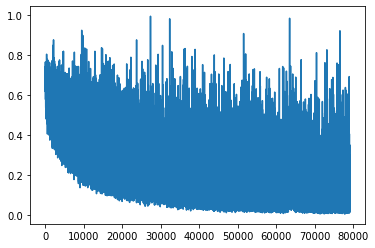

In [3]:
# fold 1
#biosnap interaction times 1e-6, flat, batch size 64, len 205, channel 3, epoch 50
s = time()
model_max, loss_history = main(1, 5e-6)
e = time()
print(e-s)
lh = list(filter(lambda x: x < 1, loss_history))
plt.plot(lh)